### Studying the integrable Harper model, not chaotic

In [1]:
import numpy as np

import matplotlib.pyplot as plt
#from scipy.integrate import odeint
import mpmath as mpmath
import scipy
from scipy.optimize import linear_sum_assignment
from scipy.optimize import curve_fit

plt.rcParams["text.usetex"] =True  # otherwise varepsilon instead of epsilon

# %matplotlib notebook 
%matplotlib inline 

import Husimi   # Quantum routines
#import Harp     # Classical integration routines
import importlib  # for reloading routines if you need to edit them

from matplotlib import colors

In [2]:
# if higher precision with mpmath 
# https://mpmath.org/
# https://mpmath.org/doc/current/matrices.html

# less relevant I think:
# this! https://github.com/c-f-h/flamp
# https://pypi.org/project/gmpy2/

In [3]:
import mpmath  # it is already installed!

In [4]:
mpmath.libmp.BACKEND   # I installed gmpy so mpmath would be faster!

'gmpy'

In [5]:
print(mpmath.mp)

Mpmath settings:
  mp.prec = 53                [default: 53]
  mp.dps = 15                 [default: 15]
  mp.trap_complex = False     [default: False]


In [6]:
mpmath.mp.dps=51  # more decimal places, precission set here
print(mpmath.mp)

Mpmath settings:
  mp.prec = 173               [default: 53]
  mp.dps = 51                 [default: 15]
  mp.trap_complex = False     [default: False]


In [6]:
# to use mpmath I have to write a special routine to fill h0 with all numbers that are specified by mpmath

### The operator studied  is $\hat h(a,b,\epsilon) = a\cos(\hat p-b) + \epsilon \cos\hat \phi $

In [7]:

# create a high precision version of operator h = a cos (p-b) + eps cos phi
def h0_prec(n,a,b,eps):
    # all constants converted to high precission numbers 
    fac = mpmath.fdiv(mpmath.fmul(mpmath.mpf(2),mpmath.pi),mpmath.mpf(int(n)))  # 2*pi/N
    h0 = mpmath.zeros(int(n)) # not complex yet
    cb = mpmath.cos(mpmath.mpf(b))  # cos b
    sb = mpmath.sin(mpmath.mpf(b))  # sin b
    afac = mpmath.fdiv(mpmath.mpf(a),mpmath.mpf(2))  # a/2
    acb = mpmath.fmul(afac,cb)  # a/2 cos b 
    asb = mpmath.fmul(afac,sb)  # a/2 sin b
    acbi = mpmath.fdiv(acb,mpmath.mpmathify(1j))  # a/2i cos b   
    asbi = mpmath.fdiv(asb,mpmath.mpmathify(1j))  # a/2i sin b
    
    # compute eps cos phi  on diagonal
    for j in range(int(n)):
        phij = mpmath.fmul(fac,mpmath.mpf(j)) #2 pi j/N
        h0[j,j] = mpmath.fmul(mpmath.mpf(eps),mpmath.cos(phij)) # fill diagonal with potential energy 
        # this gives eps cos phi on diagonal 
    
    # fill off diagonals with a/2 (cos p cos b + sin p sin b)
    for j in range(int(n)):
        h0[(j+1)%int(n),j] = mpmath.fsub(acb , asbi)
        h0[j,(j+1)%int(n)] = mpmath.fadd(acb , asbi) 
    return h0   # *mpmath.mpf(-1)  # is currently opposite sign to Husimi.hat_h_0_with_b

# get high precision eigenvalues and sort them in order of increasing energy 
# using precision routines!
def h0_prec_eigs(n,a,b,eps):
    h0 = h0_prec(int(n),mpmath.mpf(a),mpmath.mpf(b),mpmath.mpf(eps))   # converts constants to high precision numbers 
    #(w,vr) = mpmath.eigsy(h0) # returns real eigenvalues  if we have a symmetric real matrix
    (w,vr) = mpmath.eigh(h0) # use routine eigh if the matrix is complex hermitian 
    #iphi = np.argsort(w.tolist())  # sort needs a list or array to work, this keeps mpf numbers in array
    iphi = np.argsort(np.array(w))  # sort in order of energy
    w_arr = np.array(w)
    w_sort = w_arr[iphi]  # sorted energies, is a sorted array of mpfs 
    vr_arr = np.array(vr)  # is 1d
    vr_arr = np.reshape(vr_arr, (n,n)) # is 2d now
    vrsort = vr_arr[:,iphi] # sorted eigenvectors now 2d array of mpfs
    return w_sort,vrsort

# compute determinant of h0
def h0_prec_det(n,a,b,eps):
    h0 = h0_prec(int(n),mpmath.mpf(a),mpmath.mpf(b),mpmath.mpf(eps)) 
    deth = mpmath.det(h0)
    return deth

testit=0   # tests!
if (testit==1):
    a=1.0; eps = 0.1; b=0.1; n=4
    h0p = h0_prec(n,a,b,eps)
    h0p_old = Husimi.hat_h_0_with_b(n,a,b,eps) - np.identity(n)*a  # remove identity part
    #print(h0p)
    #print(h0p_old - np.identity(n)*a)
    j=2
    for i in range(n):
        print(h0p[j,i])
        print(h0p_old[j,i])   # has opposite sign but otherwise agrees!

# another quick test of routine 
(w,vr)= h0_prec_eigs(3,1.,mpmath.mpf(0),mpmath.mpf(0.1))   # n a b eps

In [8]:
importlib.reload(Husimi)  # if you need to reload these subroutines!

<module 'Husimi' from '/Users/aquillen/Desktop/summer24/pylab/QDrift/Husimi.py'>

### Illustration of Phase space circulation and libration regions

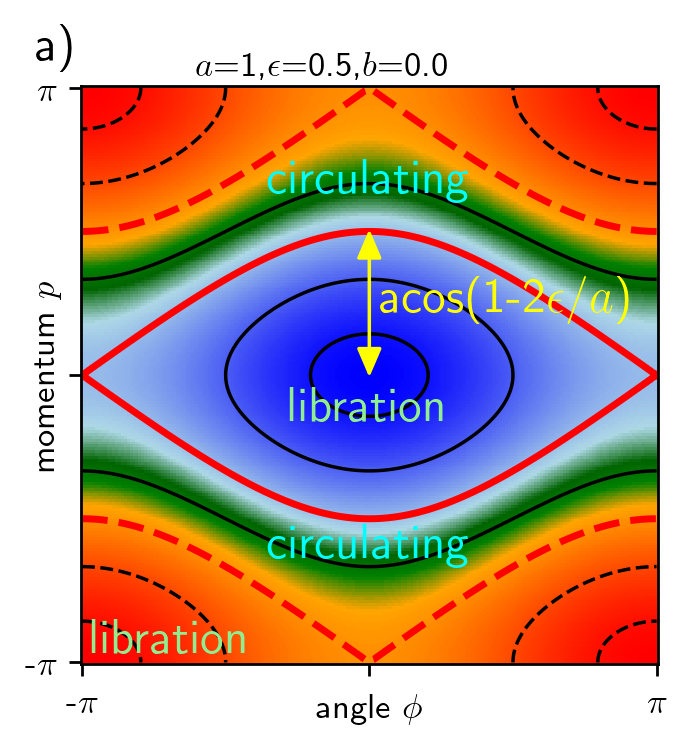

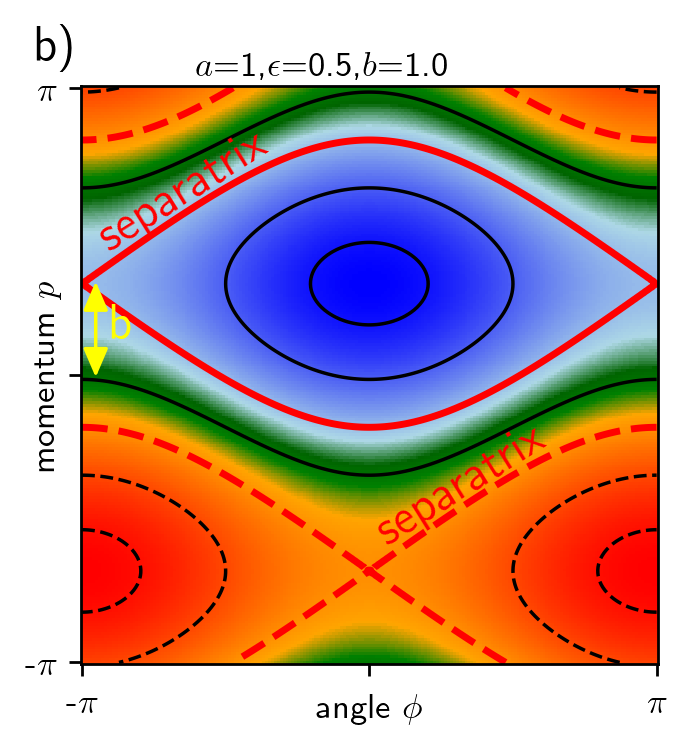

In [9]:

# make classical phase space plots for an illustration!

from matplotlib.patches import FancyArrowPatch
import matplotlib
import matplotlib.colors

def plot_contours(a,b,eps,note,ofile):

    philin = np.linspace(-np.pi,np.pi,200)
    plin = np.linspace(-np.pi,np.pi,200)
    phi_grid, p_grid = np.meshgrid(philin, plin)
    hlevs = np.cos(p_grid - b ) + epsilon*np.cos(phi_grid)

    cvals  = [-a - eps, -a + eps+0.15,-a + eps + 0.4, a - eps - 0.4,  a- eps-0.15, a + eps]
    colors = ["red","orange","green", "darkgreen","lightblue","blue"]
    norm=plt.Normalize(min(cvals),max(cvals))
    tuples = list(zip(map(norm,cvals), colors))
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)
    
    fig,ax = plt.subplots(1,1,figsize=(3,3), dpi=250)
    im = ax.pcolormesh(phi_grid,p_grid,hlevs,cmap=cmap) #'PuOr'
    sep_lower = epsilon -a 
    sep_upper = -1*sep_lower
    cc = ax.contour(phi_grid,p_grid,hlevs, levels=[sep_lower,sep_upper], colors='red',linewidths=2)
    cc = ax.contour(phi_grid,p_grid,hlevs, levels=[-1.4,-1,0,1,1.4], colors='black',linewidths=1)
    ax.set_aspect(1)
    lstring = r'$a$={:.0f},'.format(a) +  r'$\epsilon$={:.1f},'.format(epsilon) + r'$b$={:.1f}'.format(b) 
    ax.text(0.2,1.02,lstring,transform = ax.transAxes)
    ax.set_xticks(ticks=[-np.pi, 0, np.pi], labels=[r'-$\pi$', '', r'$\pi$'])
    ax.set_yticks(ticks=[-np.pi, 0, np.pi], labels=[r'-$\pi$', '', r'$\pi$'])

    if (note==1):
        arrow_style = "<|-|>,  head_width=3, head_length=7"
        arrow_properties = {
            "arrowstyle": arrow_style,
            "color": "yellow",
        }
        stretch = 0.1
        tail_position = (0, 0-stretch)
        pmax = np.arccos((1 - 2*epsilon/a))
        head_position = (0, pmax+stretch)
        arrow = FancyArrowPatch(
            tail_position,
            head_position,
            **arrow_properties, zorder=10,
        )
        ax.add_patch(arrow)
        ax.text(0 + 0.12, pmax/2-0.1, r'acos(1-2$\epsilon/a$)',color='yellow',fontsize=14) 
        ax.text(0,-0.5,'libration',color='lightgreen',ha='center',fontsize=14)
        ax.text(-np.pi+0.1,-np.pi+0.1,'libration',color='lightgreen',fontsize=14)
        ax.text(0,2,'circulating',color='cyan',ha='center',fontsize=14)
        ax.text(0,-2,'circulating',color='cyan',ha='center',fontsize=14)
        ax.text(-np.pi-0.5, np.pi+0.3,'a)',fontsize=14)

    if (note==2):
        arrow_style = "<|-|>,  head_width=3, head_length=7"
        arrow_properties = {
            "arrowstyle": arrow_style,
            "color": "yellow",
        }
        stretch = 0.1
        xpos = -np.pi + 0.15
        tail_position = (xpos, 0-stretch)
        pmax = b
        head_position = (xpos, pmax+stretch)
        arrow = FancyArrowPatch(
            tail_position,
            head_position,
            **arrow_properties, zorder=10,
        )
        ax.add_patch(arrow)
        ax.text(xpos + 0.17, pmax/2-0.1, 'b',color='yellow',fontsize=14) 
        ax.text(-np.pi+0.1,1.38,'separatrix',rotation=32,color='red',fontsize=14)
        #ax.text(-np.pi,0,'separatrix',rotation=-90,color='red')
        ax.text(0,-1.83,'separatrix',rotation=32,color='red',fontsize=14)
        ax.text(-np.pi-0.5, np.pi+0.3,'b)',fontsize=14)

    ax.text(0,-np.pi-0.6,r'angle $\phi$',ha='center')
    ax.text(-np.pi-0.4,0,r'momentum $p$',rotation=90,ha = 'center',va='center')
    
        
    if (len(ofile)>2):
        plt.savefig(ofile)
    plt.show()

a=1.; b = 0; epsilon=0.5
plot_contours(a,b,epsilon,1,'Harp1.png')

a=1.; b = 1.; epsilon=0.5
plot_contours(a,b,epsilon,2,'Harp2.png')



### Plots of distance to nearest eigenvalue  (images)

In [10]:
# for each eigenvalue in a list w_vec compute the distance to the nearest other one
# this routine uses mpmath
# return an array of dE_j
def min_de_vec(w_vec):
    n = len(w_vec)
    de_single_arr = np.zeros(n)
    for j in range(n):  # loop over eigenvalues 
        w = np.copy(w_vec)
        w[j] = mpmath.mpf(1e10)  # set its own eigenvalue to something ridiculously large so it won't contribute
        min_de = np.min(np.abs(w - w_vec[j]))  # not sure how to do this with mpmath 
        de_single_arr[j] = min_de
        #print(min_de)
    return de_single_arr

In [11]:

# sweep over n, return energies and dE_j to nearest eigenvalues
# high precision version 
# the sweep is changing only N and b is set to either 0 or pi/N, depending upon btype
# range of N from nmin to nmax-1 (no gaps, even and odd)
# returns a list of n values, a list of energies and a list of dE_j values 
def n_de_sweep(eps,btype,nmin,nmax):
    wlist = []  # eigenvals
    nlist = []  # covered values of n
    delist = [] # for each eigenval distance to nearest other one 

    a=mpmath.mpf(1.0)
    for k in range(nmin,nmax):
        n = k;  
        if (btype == 0):
            b = mpmath.mpf(0)
        else:
            b = mpmath.fdiv(mpmath.pi, mpmath.mpf(int(n)))   # b = pi/n
        n_arr = np.ones(n)*n # a list with n's in it
        nlist = np.append(nlist,n_arr)
        #(w,vr) = Husimi.h0_eigs(n,a,b,eps) # return eigenvalues, sorted in order of energy, old version 
        (w,vr) = h0_prec_eigs(n,a,b,eps) # try the higher precision version!
        wlist = np.append(wlist,w)  # was w-1 with old version 
        de_vec = min_de_vec(w)
        delist = np.append(delist,de_vec)
    return nlist,wlist,delist

# makes a figure, given list of eigenvalues and nearest energy spacings 
def mkcontour_sweep(eps,nmin,nmax,nlist,wlist,delist,minimum_number,ofile):
    fig,ax = plt.subplots(1,1,figsize=(4.5,4),dpi=250)
    plt.subplots_adjust(left=0.15,top=0.98,right=0.85,bottom=0.12)
    #minimum_number = 1e-30
    delist_log = np.log10(delist+minimum_number)
    #ax.tricontour(nlist, wlist, delist_log, levels=14, linewidths=0.5, colors='k')
    cntr2 = ax.tricontourf(nlist, wlist, delist_log,  levels=40, cmap="gnuplot")
    cbar = fig.colorbar(cntr2, ax=ax)
    cbar.set_label(r'log$_{10}$ $dE_j$')
    ax.set_xlabel(r'Number of states $N$')
    ax.set_ylabel('energy E')
    narr = np.arange(nmin,nmax)
    oarr = narr*0 + 1.0
    top = (1 - eps)*oarr  # sep!
    bottom = -1*top*oarr
    ax.plot(narr,top,'c-',lw=2)
    ax.plot(narr,bottom,'c-',lw=2)
    ymax = 1+1.3*eps
    ax.set_ylim([-ymax,ymax])
    estr = r'$\epsilon$={:.1f},$b$=0'.format(eps)  # epsilon label
    ax.text(0.1,0.95,estr,  transform=ax.transAxes)
    nmid = (nmax + nmin)/2
    ax.text(nmid,top[0]+0.1,'librating',ha='center')
    ax.text(nmid,bottom[0]-0.2,'librating',ha='center')
    ax.text(nmid,bottom[0]+0.2,'circulating',ha='center')
    if (len(ofile)>3):
        plt.savefig(ofile+'.png')
        
    plt.show()

#mkcontour_sweep(eps,nmin,nmax,nlist,wlist,delist,1e-30,'eee3')  

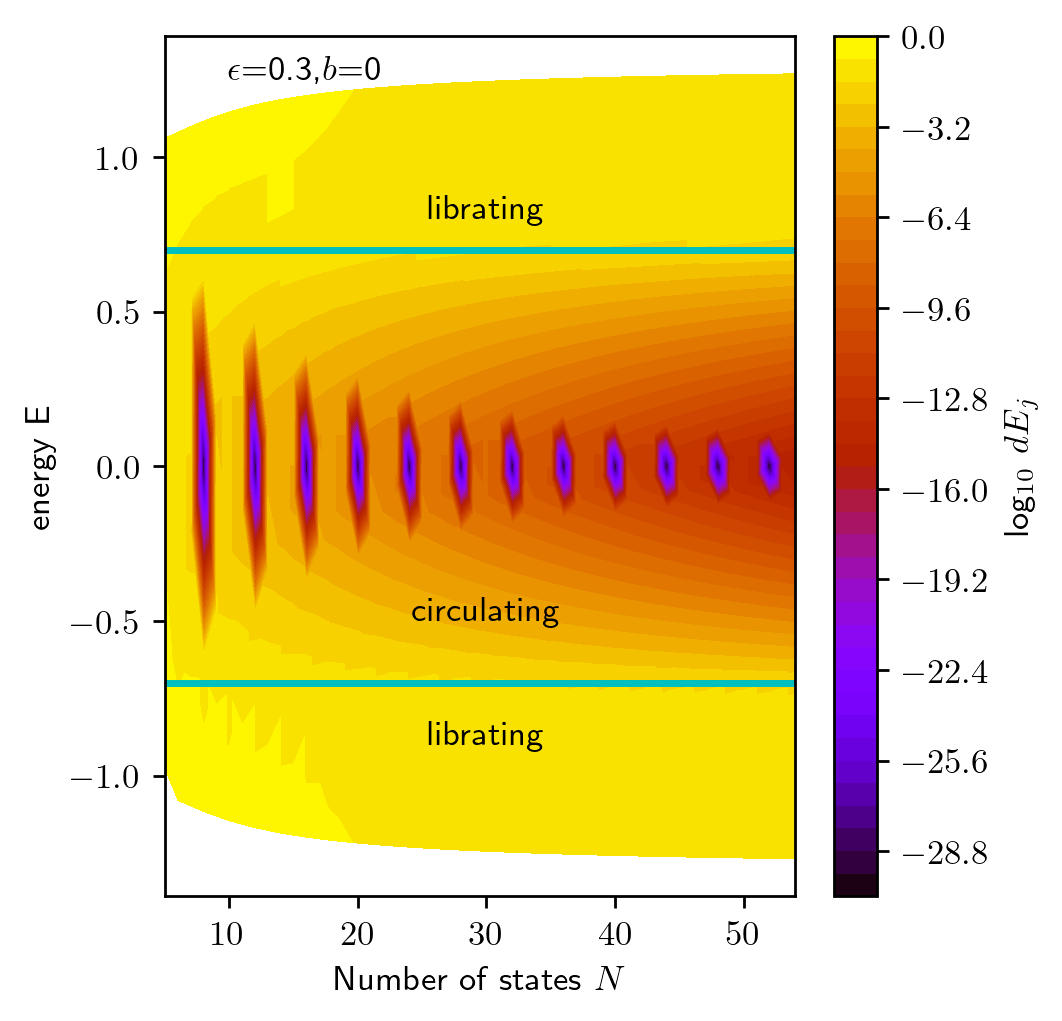

In [12]:
eps = 0.3;
nmin = 5
nmax = 55
nlist,wlist,delist = n_de_sweep(eps,0,nmin,nmax)
mkcontour_sweep(eps,nmin,nmax,nlist,wlist,delist,1e-30,'eee3')  

In [13]:
# sweep over eps, return energies and dE_j to nearest eigenvalues for a single N
# is used below to make a nice figure 
# returns a list of points eps_list all eps values used, wlist all eigenvalues,  
# de_vec the distance to closest ones for each eigenval
def e_de_sweep(eps_min,eps_max,n_eps,btype,n):
    wlist = []
    eps_list = []
    delist = []
    eps_lin = np.linspace(eps_min,eps_max,n_eps)

    a=1.0
    if (btype == 0):
        b = 0.0
    else:
        b = np.pi/n
    for k in range(n_eps):
        eps = eps_lin[k]
        #(w,vr) = Husimi.h0_eigs(n,a,b,eps) # return eigenvalues, sorted in order of energy
        (w,vr) = h0_prec_eigs(n,a,b,eps) # try the precision version! sorted via energy
        wlist = np.append(wlist,w)  # was w-1
        #wlist = np.append(wlist,w-1)  #-1 here if using previous function h0_eigs
        eps_arr = np.zeros(n) + eps 
        eps_list = np.append(eps_list,eps_arr)  
        de_vec = min_de_vec(w)
        delist = np.append(delist,de_vec)  
    return eps_list,wlist,delist

# make a figure showing a contour sweep made with above routine e_de_sweep()
# here n is number of states
# eps_list is list of epsilon values, 
# wlist, de list are energies and spacings at these epsilons
# low_lim is lower limit of de for taking log_10
def mkcontour_sweep_e(n,eps_list,wlist,delist,low_lim,alabel,ofile):
    fig,ax = plt.subplots(1,1,figsize=(4.5,4),dpi=250)
    plt.subplots_adjust(left=0.15,top=0.98,right=0.85,bottom=0.12)
    delist_log = np.log10(delist+low_lim)
    #ax.tricontour(eps_list, wlist, delist_log, levels=14, linewidths=0.5, colors='k')
    cntr2 = ax.tricontourf(eps_list, wlist, delist_log,  levels=40, cmap="gnuplot")
    cbar = fig.colorbar(cntr2, ax=ax)
    cbar.set_label(r'log$_{10}$ $dE_j$')
    ax.set_xlabel(r'Resonance strength $\epsilon$')
    ax.set_ylabel('energy E')
    eps_lin = np.linspace(np.min(eps_list),np.max(eps_list),20)
    top = (1 - eps_lin)
    bottom = -1*top
    ax.plot(eps_lin,top,'c-',lw=2)
    ax.plot(eps_lin,bottom,'c-',lw=2)
    ymax = 1+1.3*np.max(eps_list)
    ax.set_ylim([-ymax,ymax])
    estr = r'$N$={:.0f},$b$=0'.format(n)
    ax.text(0.10,0.95,estr, transform=ax.transAxes)
    ax.text(-0.0,1.55,alabel,fontsize=16)
    ax.text(np.mean(eps_list),np.mean(top)+0.2,'libration',ha='center')
    ax.text(np.mean(eps_list),np.mean(bottom)-0.3,'libration',ha='center')
    ax.text(np.mean(eps_list),0.3,'circulation',ha='center')
    if (len(ofile)>3):
        plt.savefig(ofile+'.png')
    plt.show()

#mkcontour_sweep_e(n,eps_list,wlist,delist,1e-30,'b)','fff55')

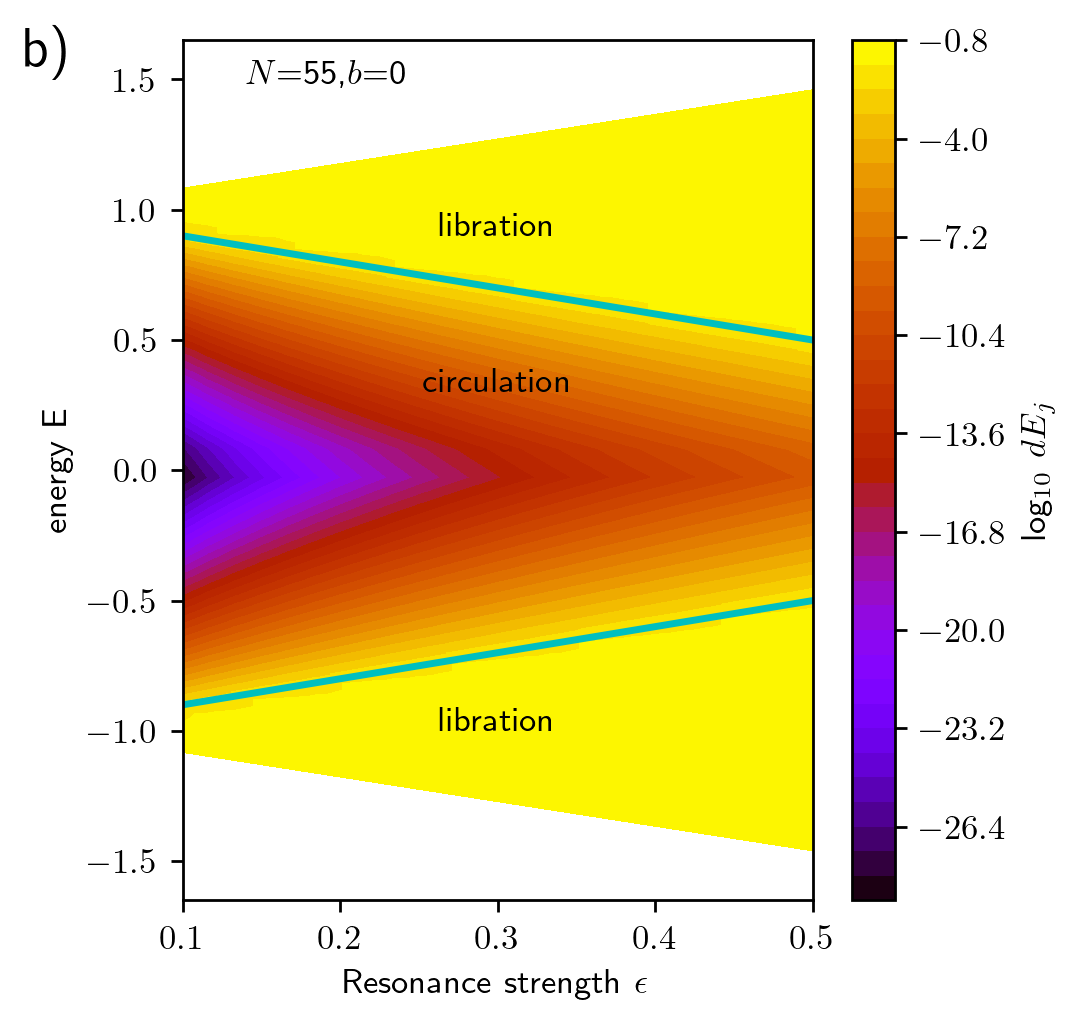

In [14]:
eps_min = 0.1
eps_max = 0.5
n_eps = 25
n=55
eps_list,wlist,delist = e_de_sweep(eps_min,eps_max,n_eps,0,n)
mkcontour_sweep_e(n,eps_list,wlist,delist,1e-30,'b)','fff55')

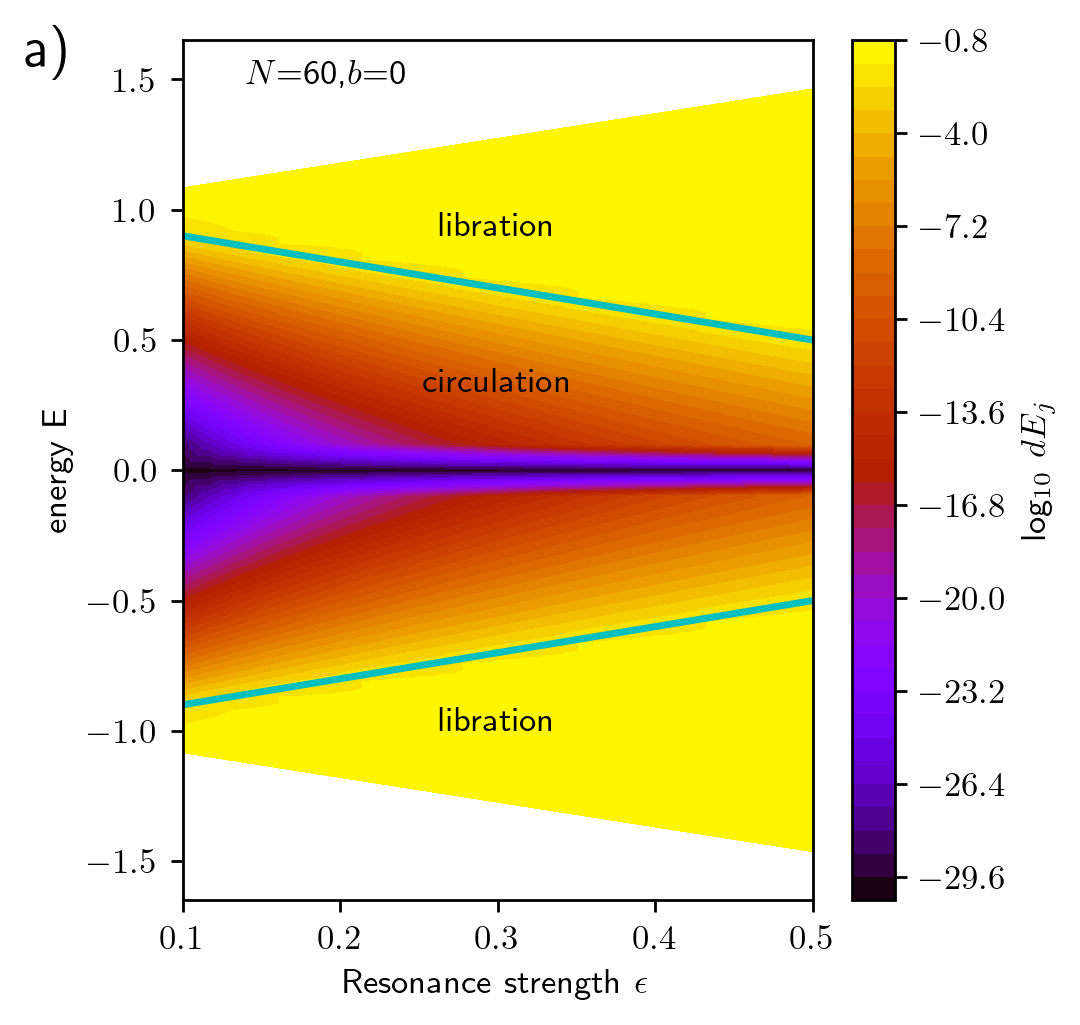

In [15]:
eps_min = 0.1
eps_max = 0.5
n_eps = 25
n=60
eps_list,wlist,delist = e_de_sweep(eps_min,eps_max,n_eps,0,n)
mkcontour_sweep_e(n,eps_list,wlist,delist,1e-30,'a)','fff60')


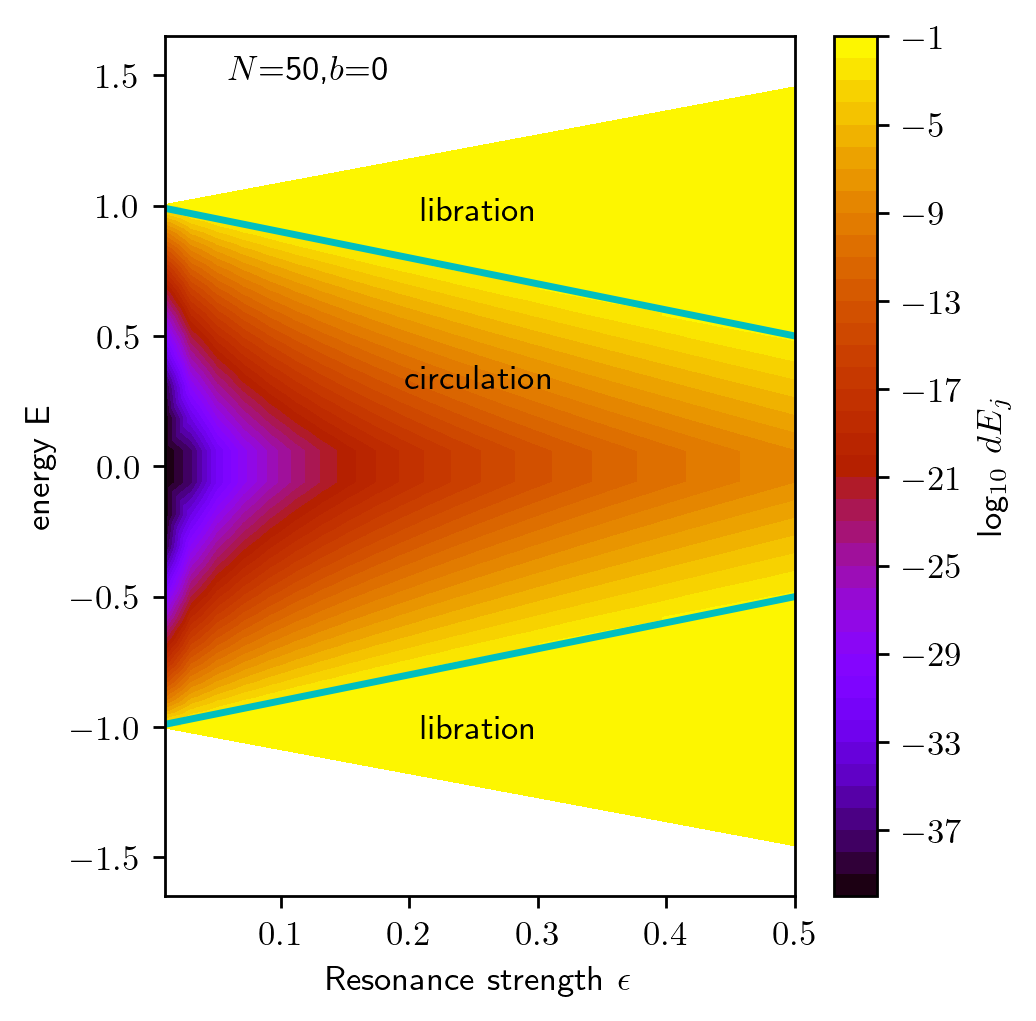

In [21]:
eps_min = 0.01
eps_max = 0.5
n_eps = 25
n=50
eps_list,wlist,delist = e_de_sweep(eps_min,eps_max,n_eps,0,n)
mkcontour_sweep_e(n,eps_list,wlist,delist,1e-40,'','')

### Instantaneous eigenvalues as a function of changing $b$ or $\epsilon$

In [16]:
# vary h0 slowly, nseries outputs computing **instantaneous** eigenvalues 
# drift rate per output is in dparms
# return sorted eigenvalues and eigenvectors, sorted in order of eigenvalue 
# uses Husimi.hat_h_0_with_b routine for computing h0
def h0_drift(n,parms0,dparms,nseries):
    w_list = np.zeros((nseries,n),dtype=float)
    vr_list = np.zeros((nseries,n,n),dtype=complex)
    for k in range(nseries):
        parms = parms0 + dparms*k  # notice drift rate 
        a = parms[0] # note the order of the parameter list, these are current parameters
        b = parms[1]
        eps = parms[2]
        #print(parms)
        if (k==0):
            print('a_init={:.6f}, b_init={:.6f}, eps_init={:.6f}'.format(a,b,eps))  # print the parameter values at the beginning 
        #mu =  parms[3]
        #mup =  parms[4]
        h0 = Husimi.hat_h_0_with_b(n,a,b,eps)  # the hamiltonian operator h_0
        (w,vr)=scipy.linalg.eigh(h0)   # find eigenvalues and eigenvectors of hermitian op
        iphi = np.argsort(np.real(w))   # sort in order of energy 
        vrsort = vr[:,iphi]   # second index gives eigenvec
        w_list[k,:] = np.real(w[iphi]) # h_0 is Hermitian so they should be real. 
        vr_list[k,:,:] = vrsort  # sorted eigenvectors 
    print('a_final={:.6f}, b_final={:.6f}, eps_final={:.6f}'.format(a,b,eps))  # print the parameter values at the end 
    return w_list,vr_list 

# a class structure to hold drifting unperturbed system
# calls above routine h0_drift
class h0_drift_class():
    def __init__(self,n,parms0,dparms,nseries):
        self.n = n
        self.nseries = nseries
        self.parms0 = parms0
        self.dparms = dparms
        self.a_0   = parms0[0] # note the order of the parameter list, these are current parameters
        self.b_0   = parms0[1]
        self.eps_0 = parms0[2]
        self.d_a   = dparms[0]
        self.d_b   = dparms[1]
        self.d_eps = dparms[2]
        self.parms_final = parms0 + (self.nseries-1)*dparms
        self.a_final   = self.parms_final[0]
        self.b_final   = self.parms_final[1]
        self.eps_final = self.parms_final[2]
        print('parms_final', self.parms_final)

        # some vectors that display ranges 
        self.iis = np.arange(self.nseries)
        self.a_range = self.a_0 + self.d_a*self.iis 
        self.b_range = self.b_0 + self.d_b*self.iis 
        self.eps_range = self.eps_0 + self.d_eps*self.iis 
        
        # compute series of instantaneous eigenvalues and eigenvectors 
        self.w_list,self.vr_list  = h0_drift(self.n,self.parms0,self.dparms,self.nseries)  
        # note this routine uses Husimi.hat_h0_with_b
        self.de_singles = min_de_singles(self.w_list)  # compute distance to nearest eigenvalues  low precission!
        #vr_list[k,:,:] = vrsort  # eigenvectors at time k

    def compute_U(self,T,ntau):  # compute propagator across the drift 
        self.ntau = ntau
        self.T = T
        # h0_Udrift(N,T,ntau,parms0,d_parms) # compute propagator across the drift 
        self.w_s,self.vr_s,self.U_final = h0_Udrift(self.n,T,ntau,self.parms0,self.parms_final) 
        # compute propagator across the drift 

    def compute_U2(self,T,ntau):  # compute propagator across the drift using a different routine
        # drift over duration T/hbar to self.parms_final 
        self.ntau = ntau
        self.T = T
        # h0_Udrift(N,T,ntau,parms0,d_parms) # compute propagator across the drift using the other routine
        self.w_s,self.vr_s,self.U_final = h0_Udrift2(self.n,T,ntau,self.parms0,self.parms_final) 
      

# returns the closest distance to next nearest energy for each eigenvalue at each time in the series
# w_list is a series of eigenvalues for the whole series
def min_de_singles(w_list):
    nseries = w_list.shape[0]
    n = w_list.shape[1]
    de_singles_list = np.zeros([nseries,n])
    for k in range(nseries):  # each in the series 
        w_vec = np.squeeze(w_list[k,:])  # list of eigenvalues 
        for j in range(n):
            w = np.copy(w_vec)
            w[j] = 1e10   # set itself to something ridiculously large
            min_de = np.min(np.abs(w - w_vec[j]))
            de_singles_list[k,j] = min_de  # each eigenvalue has a min distance to nearest 
    return de_singles_list 
        

In [40]:
# compute separatix energy as a function of time 
# consistent with h0 defined in Husimi.py which is a(1-cos p-b) - eps cos phi
def sep_energy(h0class):
    #a_vec = h0class.parms0[0] + h0class.dparms[0] * h0class.iis
    #eps_vec = h0class.parms0[2] + h0class.dparms[2] * h0class.iis
    top = 2*h0class.a_range - h0class.eps_range
    bottom = h0class.eps_range 
    return bottom,top  # separatrix energies as a function of time
    # subtract a if you want to remove the contant term and are using the old version of hat h



# make a figure showing eigenvalues for a drifting series 
# energy is shifted by a and flipped if shift_E = True
# color shows distance to nearest eigenvalue
def show_eigs(h0class,i0,i1,ymin,ymax,show_labels,ofile):
    #i0=0;i1=nseries typically for entire range
    shift_E = True  # whether or not E is shifted so that centered at 0
    # because we used Husimi.h0 to compute the eigenvalues,  they calculated with LAPACK and h0 is that of quillen+25 
    # and is h0 = a(1-cos p) - \epsilon \phi 
    # instead of 
    # h = a cos p + epsilon cos phi
    fig,ax = plt.subplots(1,1,figsize=(5,4),dpi=300)
    n  = h0class.n 
    
    if (h0class.d_b ==0):
        xx = h0class.eps_range[i0:i1]
        ax.set_xlabel(r'resonance strength $\epsilon$')
    else:
        xx = h0class.b_range[i0:i1]
        ax.set_xlim([np.min(h0class.b_range[i0:i1]),np.max(h0class.b_range[i0:i1])])
        ax.set_xlabel(r'resonance center $b$')

    if (h0class.d_b !=0) and (h0class.d_eps ==0):
        fac = np.pi/n
        ax2 = ax.twiny()
        ax2.set_xlim([np.min(h0class.b_range[i0:i1])/fac,np.max(h0class.b_range[i0:i1])/fac])
        ax2.set_xlabel(r'$bN/\pi$')

    if (h0class.d_b !=0) and (h0class.d_eps !=0):
        ax2 = ax.twiny()
        ax2.set_xlim([np.min(h0class.eps_range[i0:i1]),np.max(h0class.eps_range[i0:i1])])
        ax2.set_xlabel(r'resonance strength $\epsilon$')
        
    bottom,top = sep_energy(h0class)
    # plot separatrices 
    lw_sep=2
    if (shift_E == True): # notice shift in energy!
        ax.plot(xx, bottom[i0:i1] - h0class.a_0,'r:',alpha=0.3,label='separatrix',lw=lw_sep) # separatrix vals
        ax.plot(xx, top[i0:i1] - h0class.a_0 ,'r:',alpha=0.3,lw=lw_sep)
        # only plotting the sep positions in the index range i0:i1 
    else: 
        ax.plot(xx, bottom[i0:i1] ,'r:',alpha=0.3,label='separatrix',lw=lw_sep) # separatrix vals
        ax.plot(xx, top[i0:i1] ,'r:',alpha=0.3,lw=lw_sep)
    
    colormap = plt.cm.viridis #or any other colormap
    normalize = colors.Normalize(vmin=-8, vmax=-0.3)

    for k in range(n):
        if (shift_E == True): # notice shift in energy! and minus sign 
            yy = -1*(np.squeeze(h0class.w_list[i0:i1,k]) - h0class.a_0 )  
        else: 
            yy = np.squeeze(h0class.w_list[i0:i1,k])   # no shift in energy here!!!!!
            
        de = np.squeeze(np.log10(h0class.de_singles[i0:i1,k] + 1e-9))
        #ax.plot(xx, yy, 'k-',lw=0.5,alpha=0.5) 
        ss = ax.scatter(xx, yy, c=de, s=0.2, cmap=colormap, norm=normalize, marker='.')

    ax.set_ylim([ymin,ymax])
    ax.set_ylabel('Eigenvalues E')
    #plt.colorbar(ss)

    cbar = fig.colorbar(ss, ax=ax)
    cbar.set_label(r'log$_{10} dE_j$')

    if (show_labels==1):
        ax.text(0.2,0,'circulating')
        xl = 0.75*(np.max(xx) - np.min(xx)) + np.min(xx)
        ax.text(xl,1,'librating')
        ax.text(xl,-1,'librating')
        ax.legend(loc='upper left',handletextpad=0.4)

        nstr = r'$N$={:d}'.format(n)
        if (h0class.d_b ==0) and (h0class.b_0 ==0):
            nstr += r',$b$=0'
        if (h0class.d_eps ==0):
            nstr += r',$\epsilon$={:.1f}'.format(h0class.eps_0)
        ax.text(0.05, 0.05, nstr, horizontalalignment='left',\
            verticalalignment='center', transform=ax.transAxes)

    if (len(ofile)>2):
        outfile = ofile + '_h0drift.png'
        plt.savefig(outfile)
        print(outfile)

    plt.show()



parms_final [1.         0.         0.99676667]
a_init=1.000000, b_init=0.000000, eps_init=0.000100
a_final=1.000000, b_final=0.000000, eps_final=0.996767
cc1_h0drift.png


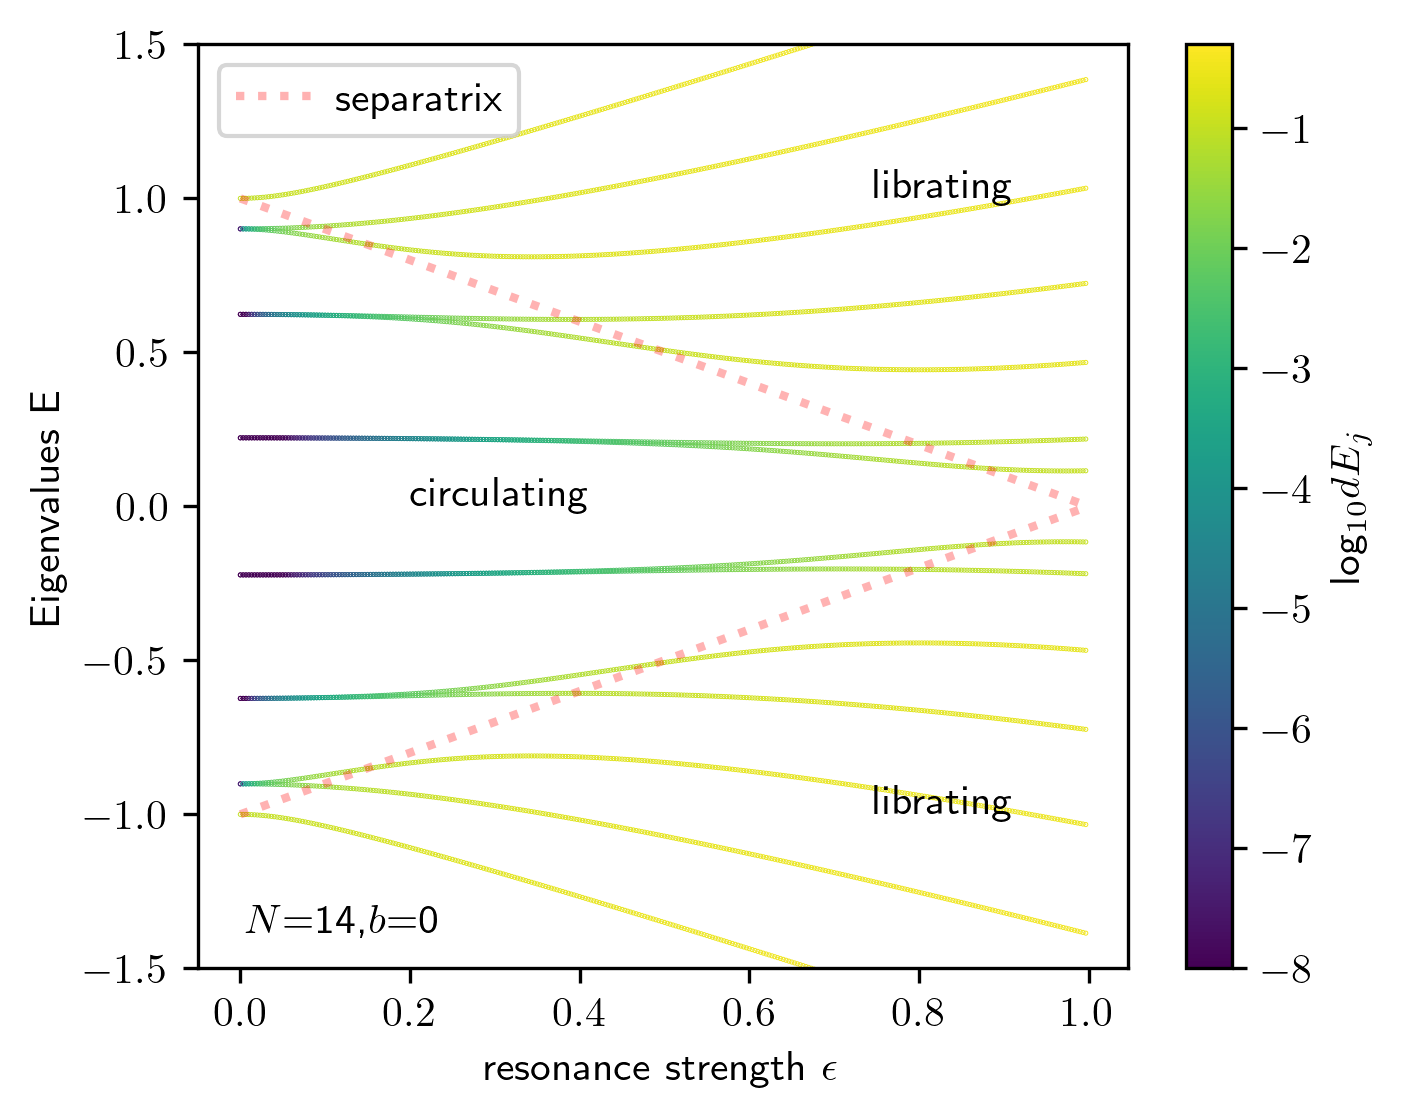

In [41]:
n=14; a=1.0; eps=0.0001; b=0.0; parms0 = np.array([a,b,eps])
nseries=300
d_a = 0.0; d_b = 0 ; d_eps = 1.0/nseries; 
dparms = np.array([d_a,d_b,d_eps])
cc1   = h0_drift_class(n,parms0,dparms,nseries)
ymin = -1.5; ymax = 1.5
show_eigs(cc1,0,cc1.nseries,ymin,ymax,1,'cc1')

parms_final [1.         0.62622414 0.3       ]
a_init=1.000000, b_init=0.000000, eps_init=0.300000
a_final=1.000000, b_final=0.626224, eps_final=0.300000
cc2_h0drift.png


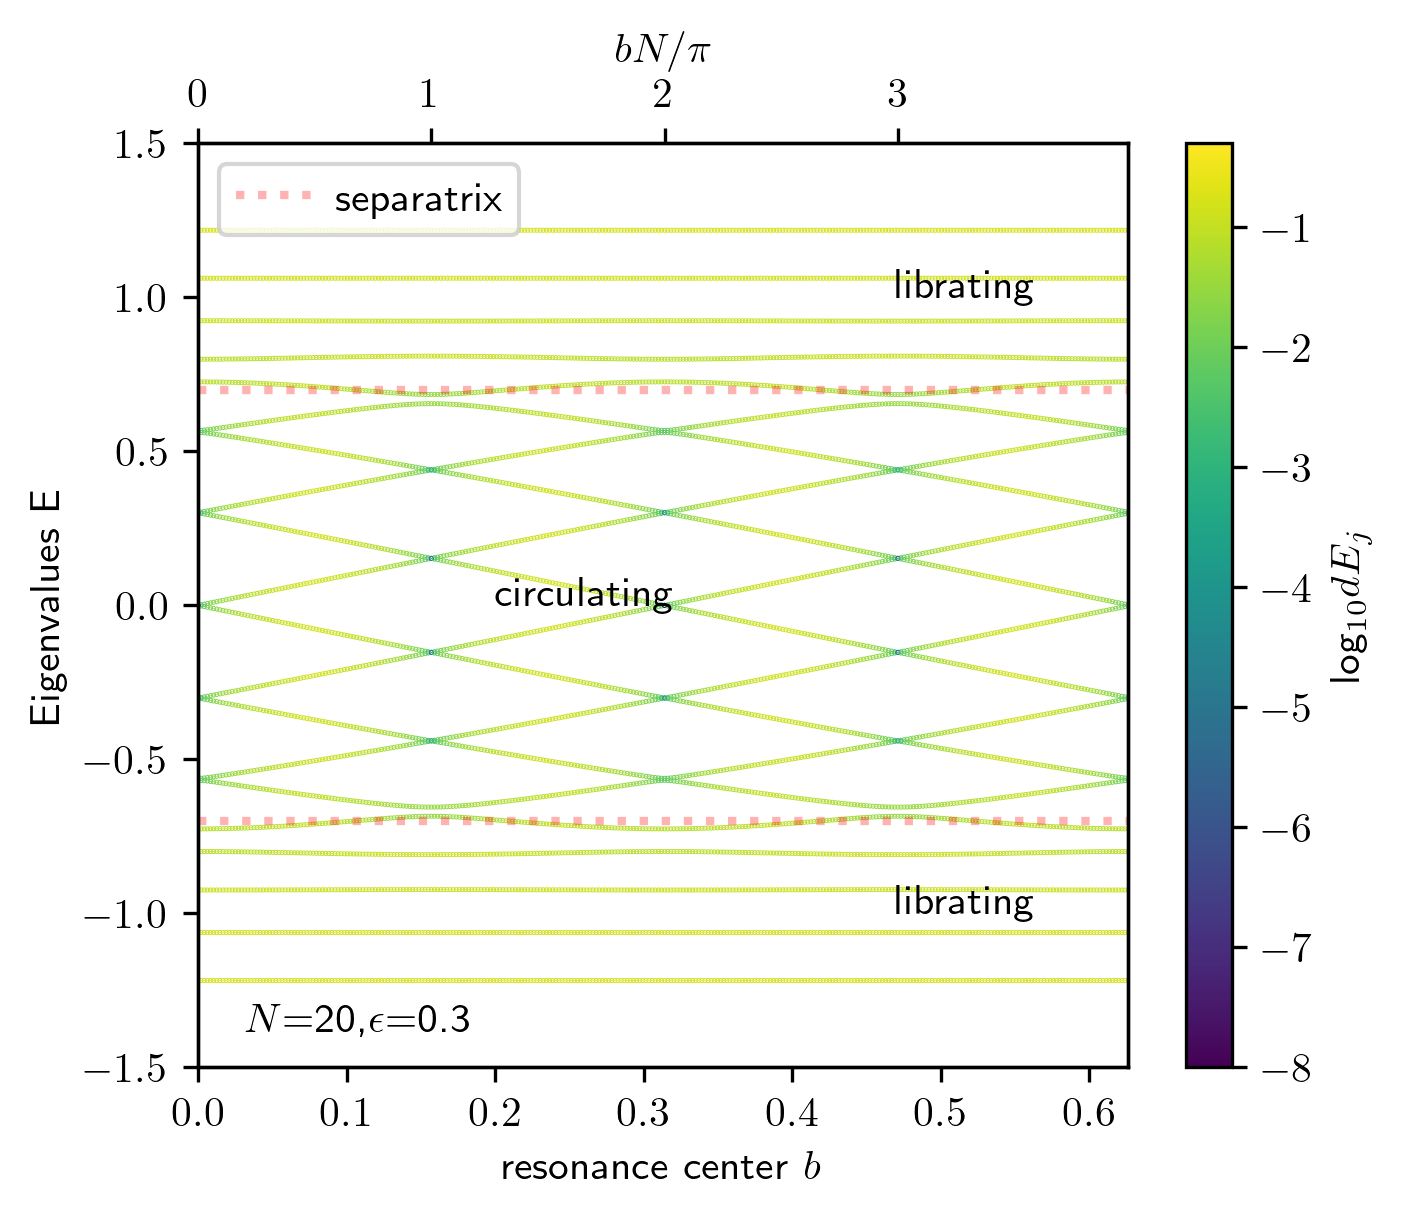

In [42]:
n=20; a=1.0; eps=0.3; b=0.0; parms0 = np.array([a,b,eps])
nseries=300
d_a = 0.0; d_b = (np.pi/n)*4/nseries ; d_eps = 0.0/nseries; 
dparms = np.array([d_a,d_b,d_eps])
cc2   = h0_drift_class(n,parms0,dparms,nseries)
ymin = -1.5; ymax = 1.5
show_eigs(cc2,0,cc2.nseries,ymin,ymax,1,'cc2')

parms_final [1.         2.29106391 0.5001    ]
a_init=1.000000, b_init=0.000000, eps_init=0.000100
a_final=1.000000, b_final=2.291064, eps_final=0.500100
cc3_h0drift.png


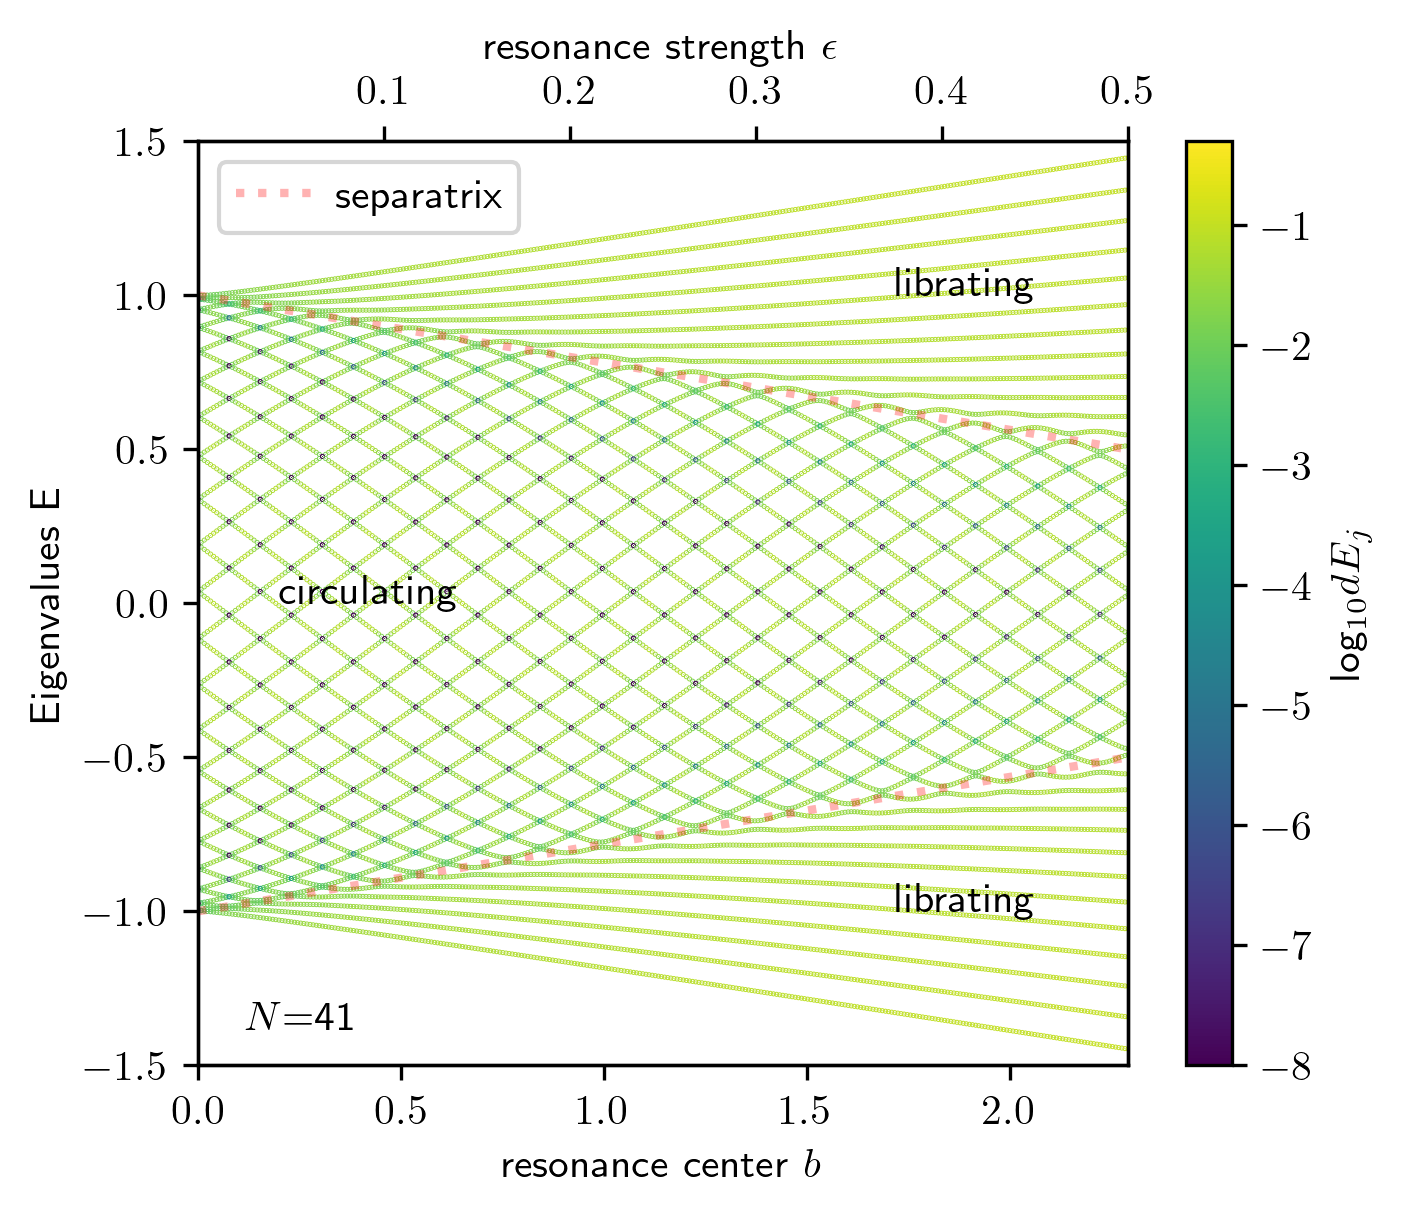

In [43]:
n=41; a=1.0; eps=0.0001; b=0.0; parms0 = np.array([a,b,eps])
nseries=300
d_a = 0.0; d_b = (2*np.pi/n)/20 ; d_eps = 0.5/(nseries-1); 
dparms = np.array([d_a,d_b,d_eps])
cc3   = h0_drift_class(n,parms0,dparms,nseries)
ymin = -1.5; ymax = 1.5
show_eigs(cc3,0,cc3.nseries,ymin,ymax,1,'cc3')

parms_final [1.         2.29106391 0.5001    ]
a_init=1.000000, b_init=0.000000, eps_init=0.000100
a_final=1.000000, b_final=2.291064, eps_final=0.500100
cc3_nolabels_h0drift.png


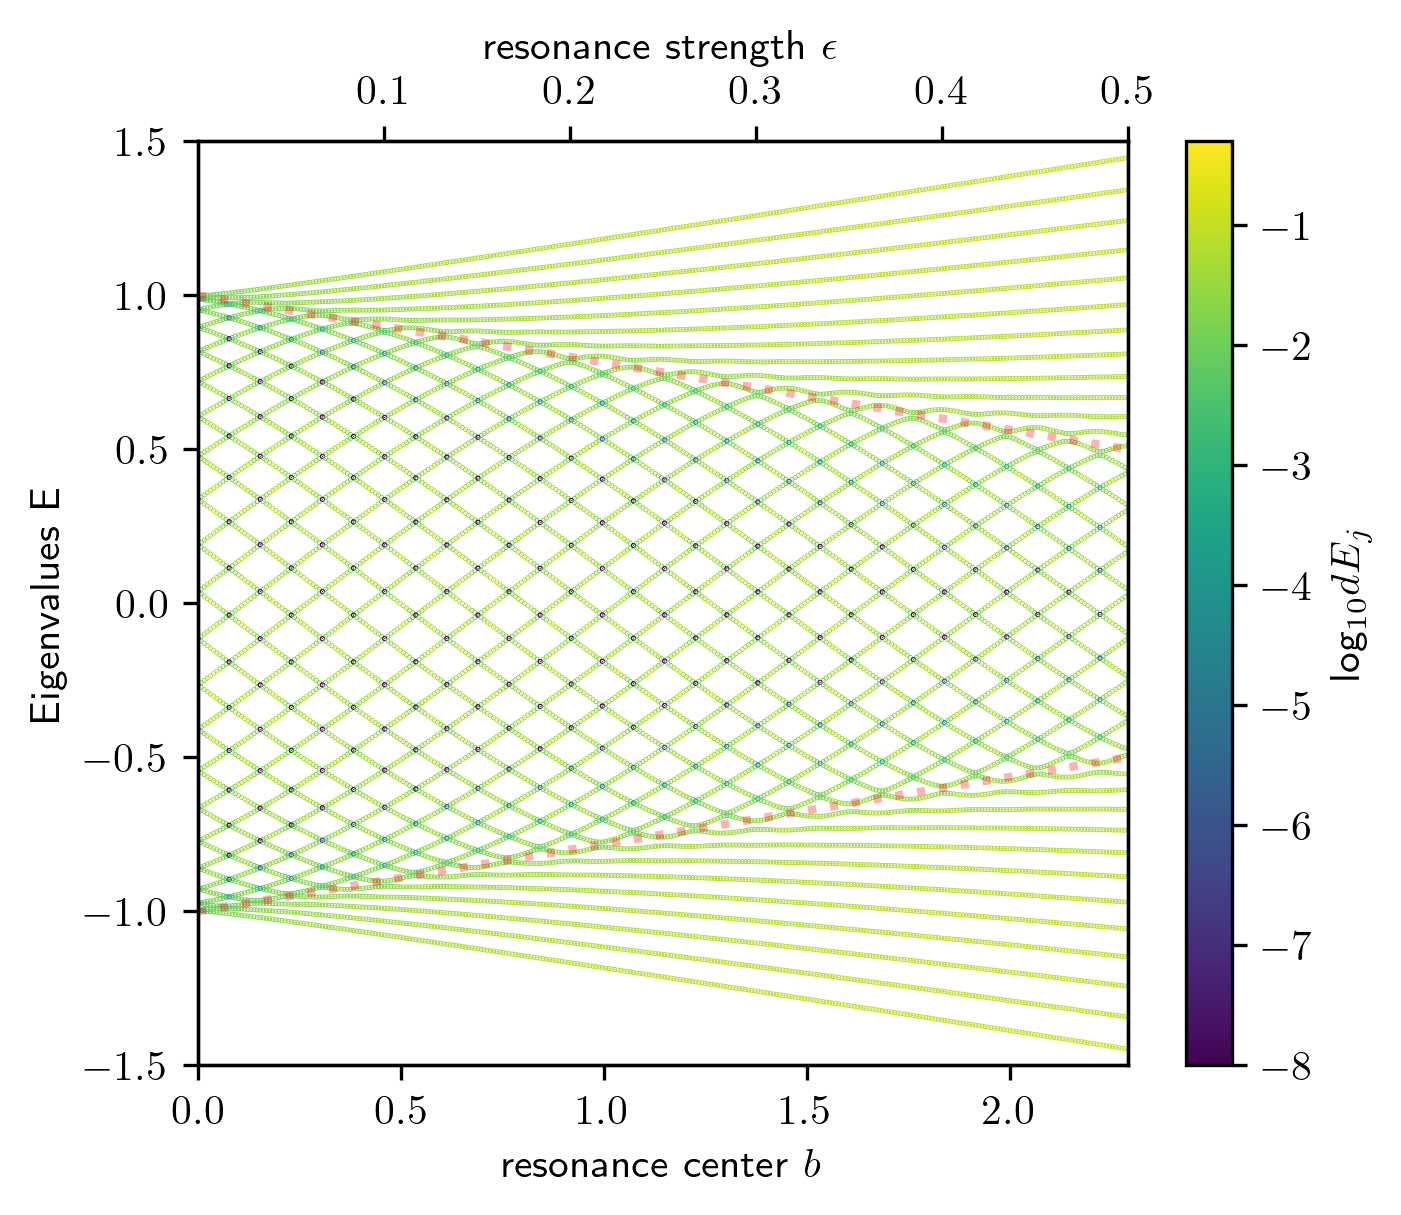

In [44]:
n=41; a=1.0; eps=0.0001; b=0.0; parms0 = np.array([a,b,eps])
nseries=300
d_a = 0.0; d_b = (2*np.pi/n)/20 ; d_eps = 0.5/(nseries-1); 
dparms = np.array([d_a,d_b,d_eps])
cc3   = h0_drift_class(n,parms0,dparms,nseries)
ymin = -1.5; ymax = 1.5
show_eigs(cc3,0,cc3.nseries,ymin,ymax,0,'cc3_nolabels')

parms_final [1.         0.         0.99676667]
a_init=1.000000, b_init=0.000000, eps_init=0.000100
a_final=1.000000, b_final=0.000000, eps_final=0.996767


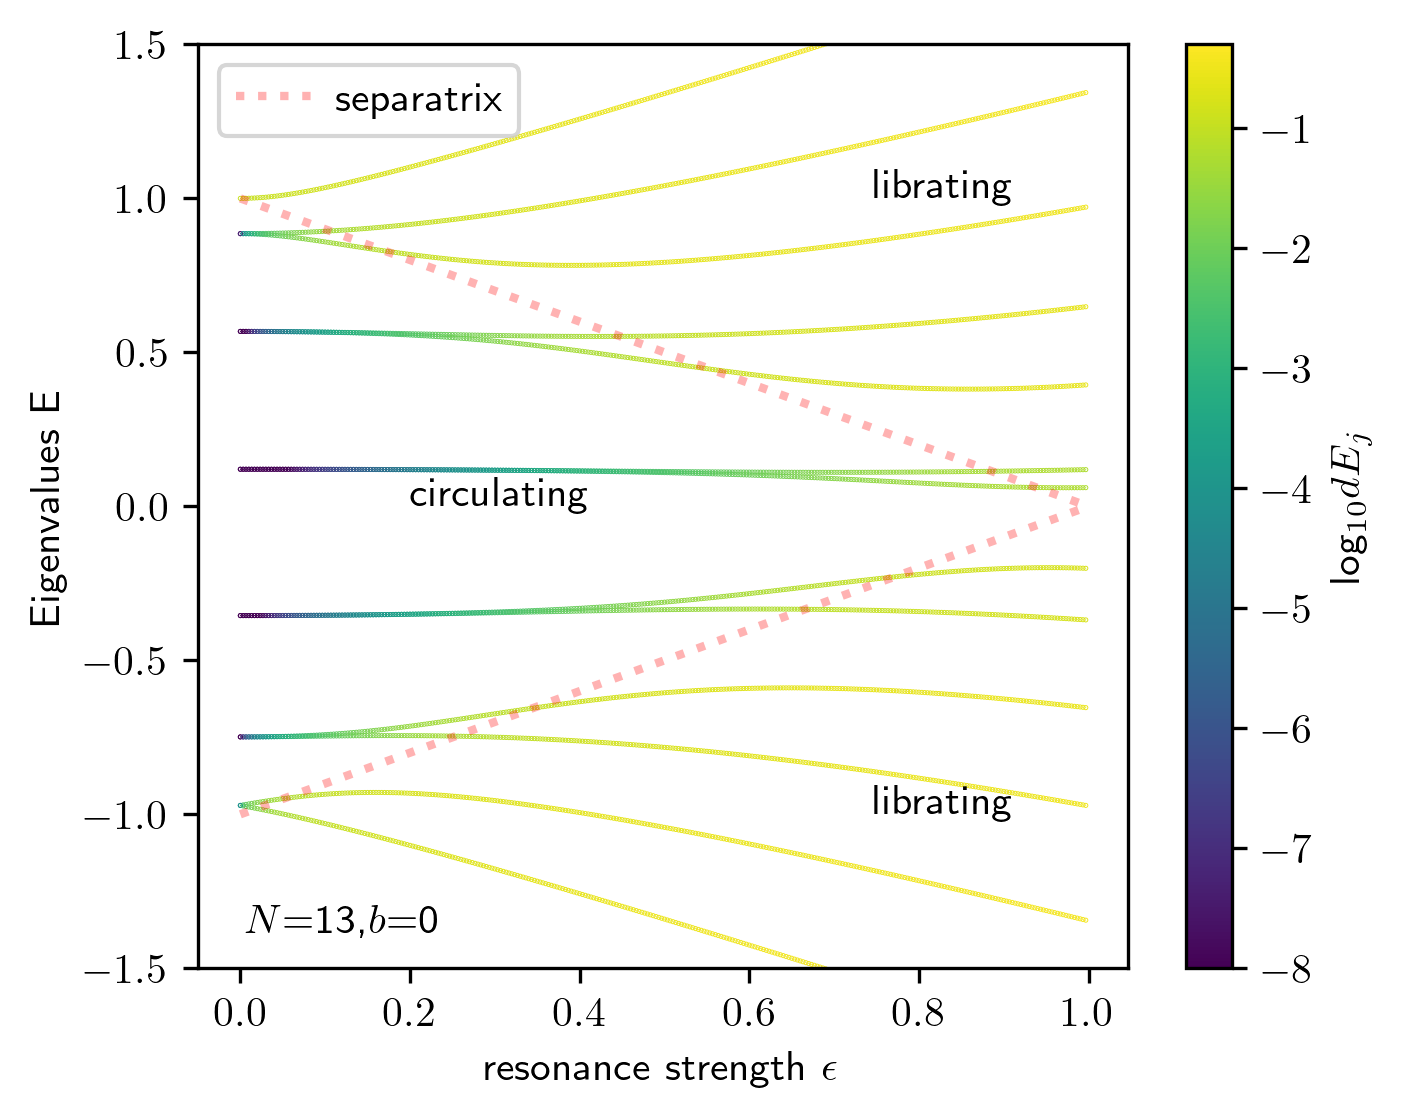

In [49]:
n=13; a=1.0; eps=0.0001; b=0.0; parms0 = np.array([a,b,eps])
nseries=300
d_a = 0.0; d_b = 0 ; d_eps = 1.0/nseries; 
dparms = np.array([d_a,d_b,d_eps])
cc1   = h0_drift_class(n,parms0,dparms,nseries)
ymin = -1.5; ymax = 1.5
show_eigs(cc1,0,cc1.nseries,ymin,ymax,1,'')

### figures showing minimum $dE_j$ as a function of $N$ and $\epsilon$

In [22]:
# computing neareast spacing for N multiple of 2 but not of 4, loop over n up to nmax
def nn_both(nmax,a,btype,eps,ntype):
    if (ntype == 'even'):
        nvals = np.arange(6,nmax,4)
    else:
        nvals = np.arange(7,nmax,2)
    minvals = []  # get minimum spacing 
    dets = []  # compute determinant
    for k in range(len(nvals)):  
        n = nvals[k]
        if (btype ==0):
            b=0
        else:
            b = np.pi/n
        (w,vr) = h0_prec_eigs(n,a,b,eps) # try the precision version!
        de_vec = min_de_vec(w)
        minval = np.min(de_vec)
        minvals = np.append(minvals,minval)
        deth = float(mpmath.re(h0_prec_det(n,a,b,eps)))
        dets = np.append(dets,deth)
    return minvals,nvals,dets

# compute the even ones
ntype = 'even'
nmax = 50; a=1;
btype=0;  # b=0 for this computation!
eps_lin = np.array([0.1,0.3,0.5,0.7,0.9])  # eps_lin defined here!!!!

minvals1a,nvalsa,dets1a = nn_both(nmax,a,btype,eps_lin[0],ntype)
minvals2a,nvalsa,dets2a = nn_both(nmax,a,btype,eps_lin[1],ntype)
minvals3a,nvalsa,dets3a = nn_both(nmax,a,btype,eps_lin[2],ntype)
minvals4a,nvalsa,dets4a = nn_both(nmax,a,btype,eps_lin[3],ntype)
minvals5a,nvalsa,dets5a = nn_both(nmax,a,btype,eps_lin[4],ntype)

btype=1;  # b=pi/N now!
minvals1c,nvalsc,dets1c = nn_both(nmax,a,btype,eps_lin[0],ntype)
minvals2c,nvalsc,dets2c = nn_both(nmax,a,btype,eps_lin[1],ntype)
minvals3c,nvalsc,dets3c = nn_both(nmax,a,btype,eps_lin[2],ntype)
minvals4c,nvalsc,dets4c = nn_both(nmax,a,btype,eps_lin[3],ntype)
minvals5c,nvalsc,dets5c = nn_both(nmax,a,btype,eps_lin[4],ntype)


# function that seems to work to describe minimum gap size
def etry_fun(evals,n,ntype):
    if (ntype == 'even'):
        return np.log10(evals**((n-2)/2) * 5/n)
    else:
        return np.log10(evals**((n-1)/2) * 3/n)



In [23]:
# now do the odd N ones
ntype = 'odd'
nmax = 50; a=1;
btype=0;  #  b=0 for this computation!
#eps_lin = np.array([0.1,0.3,0.5,0.7,0.9]) # same as for even ones

minvals1b,nvalsb,dets1b = nn_both(nmax,a,btype,eps_lin[0],ntype)
minvals2b,nvalsb,dets2b = nn_both(nmax,a,btype,eps_lin[1],ntype)
minvals3b,nvalsb,dets3b = nn_both(nmax,a,btype,eps_lin[2],ntype)
minvals4b,nvalsb,dets4b = nn_both(nmax,a,btype,eps_lin[3],ntype)
minvals5b,nvalsb,dets5b = nn_both(nmax,a,btype,eps_lin[4],ntype)

btype=1; # b = pi/N
minvals1d,nvalsd,dets1d = nn_both(nmax,a,btype,eps_lin[0],ntype)
minvals2d,nvalsd,dets2d = nn_both(nmax,a,btype,eps_lin[1],ntype)
minvals3d,nvalsd,dets3d = nn_both(nmax,a,btype,eps_lin[2],ntype)
minvals4d,nvalsd,dets4d = nn_both(nmax,a,btype,eps_lin[3],ntype)
minvals5d,nvalsd,dets5d = nn_both(nmax,a,btype,eps_lin[4],ntype)


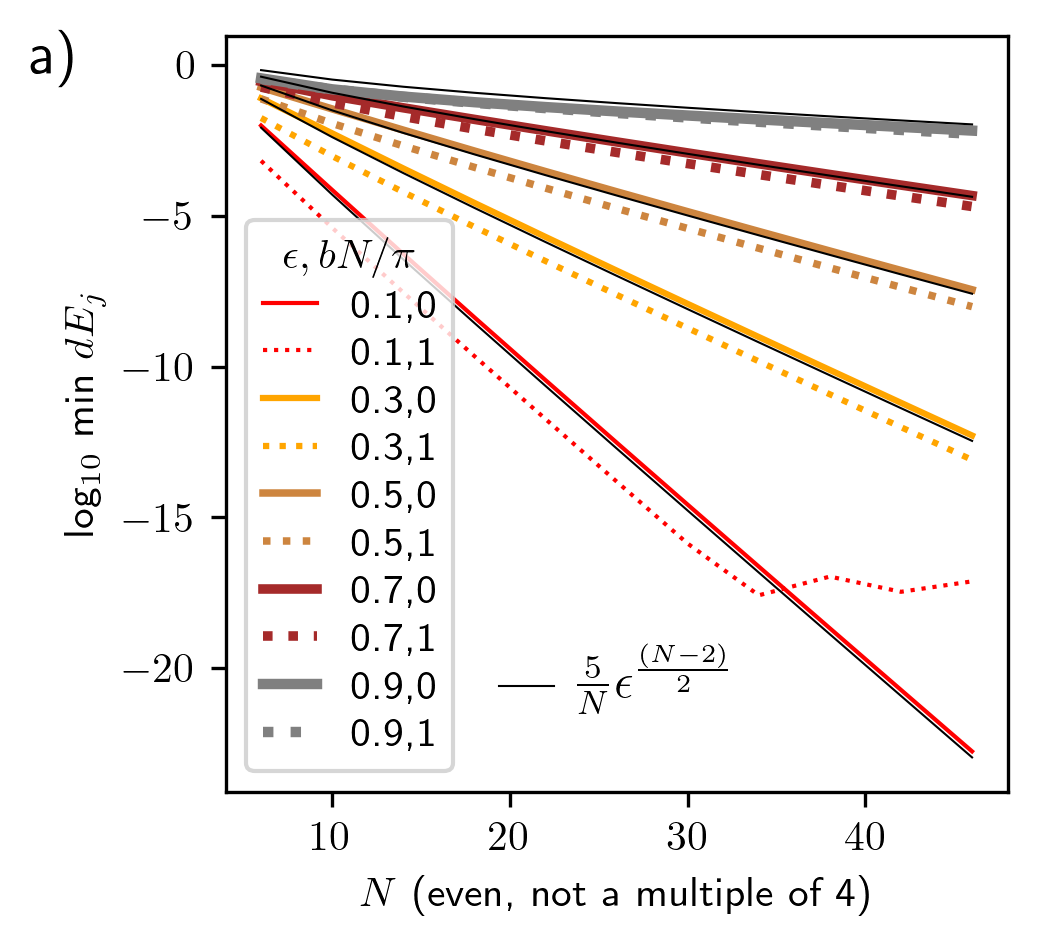

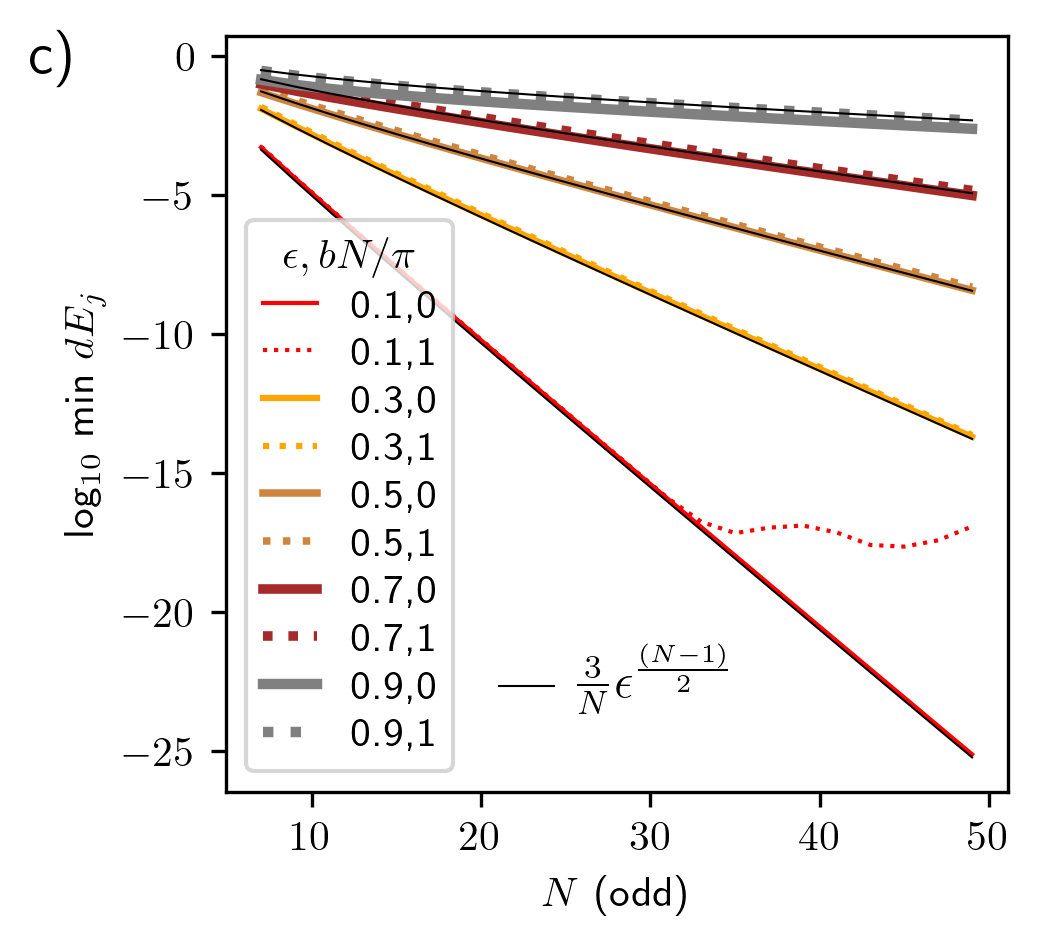

In [24]:
# make figures showing how min spacing depends upon N
def mk_n_fig(nvals,min1a,min1c,min2a,min2c,min3a,min3c,min4a,min4c,min5a,min5c,eps_lin,ntype,ofile):
    fig,ax = plt.subplots(1,1,figsize=(3.3,3),dpi=300)
    plt.subplots_adjust(bottom=0.15, left=0.2, top=0.99, right=0.99)
    color_list = ['red','orange','peru','brown','grey']
    #color_list2 = ['indianred','tomato','chocolate','darkred','dimgrey']
    lw_list = np.array([1,1.5,1.8,2.3,2.5])
    #lw_list2 = np.array([1,1,1,1,1])
    handles1 = []

    k=0; 
    lww,=ax.plot(nvals,np.log10(min1a),'-',label='{:.1f},0'.format(eps_lin[k]),lw=lw_list[k],color=color_list[k])
    handles1.append(lww)
    lww,=ax.plot(nvals,np.log10(min1c),':',label='{:.1f},1'.format(eps_lin[k]),lw=lw_list[k],color=color_list[k])
    handles1.append(lww)
    
    k=1; 
    lww,=ax.plot(nvals,np.log10(min2a),'-',label='{:.1f},0'.format(eps_lin[k]),lw=lw_list[k],color=color_list[k])
    handles1.append(lww)
    lww,=ax.plot(nvals,np.log10(min2c),':',label='{:.1f},1'.format(eps_lin[k]),lw=lw_list[k],color=color_list[k])
    handles1.append(lww)

    k=2; 
    lww,=ax.plot(nvals,np.log10(min3a),'-',label='{:.1f},0'.format(eps_lin[k]),lw=lw_list[k],color=color_list[k])
    handles1.append(lww)
    lww,=ax.plot(nvals,np.log10(min3c),':',label='{:.1f},1'.format(eps_lin[k]),lw=lw_list[k],color=color_list[k])
    handles1.append(lww)

    k=3; 
    lww,=ax.plot(nvals,np.log10(min4a),'-',label='{:.1f},0'.format(eps_lin[k]),lw=lw_list[k],color=color_list[k])
    handles1.append(lww)
    lww,=ax.plot(nvals,np.log10(min4c),':',label='{:.1f},1'.format(eps_lin[k]),lw=lw_list[k],color=color_list[k])
    handles1.append(lww)

    k=4; 
    lww,=ax.plot(nvals,np.log10(min5a),'-',label='{:.1f},0'.format(eps_lin[k]),lw=lw_list[k],color=color_list[k])
    handles1.append(lww)
    lww,=ax.plot(nvals,np.log10(min5c),':',label='{:.1f},1'.format(eps_lin[k]),lw=lw_list[k],color=color_list[k])
    handles1.append(lww)

    ax.legend(handlelength=1.3,title=r'$\epsilon,bN/\pi$',labelspacing=0.25,title_fontsize=10)  # measurement key

    # model lines 
    for k in range(len(eps_lin)):
        ax.plot(nvals,etry_fun(eps_lin[k],nvals,ntype),'-',lw = 0.5,color='black')
    
    ylabel = r'log$_{10}$ ' + r'min $dE_j$'
    ax.set_ylabel(ylabel)
    if (ntype == 'even'):
        ax.set_xlabel(r'$N$ (even, not a multiple of 4)')
        label =  r'$\frac{5}{N}$'
        label += r'$\epsilon^{\frac{(N-2)}{2}}$' 
        ax.text(-0.25,0.95,'a)',  transform =  ax.transAxes,fontsize=14)
    else:
        ax.set_xlabel(r'$N$ (odd)')
        label =    r'$\frac{3}{N}$'
        label += r'$\epsilon^{\frac{(N-1)}{2}}$' 
        ax.text(-0.25,0.95,'c)',  transform =  ax.transAxes,fontsize=14)

    ax.plot([0.35,0.42],[0.14,0.14], 'k-', lw=0.5, transform =  ax.transAxes)
    ax.text(0.45,0.15,label, transform =  ax.transAxes,fontsize=12,va='center') # show model label
    plt.savefig(ofile)
    plt.show()

ntype = 'even'
mk_n_fig(nvalsa,minvals1a,minvals1c,minvals2a,minvals2c,minvals3a,minvals3c,minvals4a,minvals4c,\
         minvals5a,minvals5c,eps_lin,ntype,'even_n.png')
ntype = 'odd'
mk_n_fig(nvalsb,minvals1b,minvals1d,minvals2b,minvals2d,minvals3b,minvals3d,minvals4b,minvals4d,\
         minvals5b,minvals5d,eps_lin,ntype,'odd_n.png')

In [25]:
# computing nearest energy spacing , loop over eps, N could be even or odd
def enboth(n,a,btype,emin,emax,ne):
    evals = np.linspace(emin,emax,ne)
    eminvals = []
    dets = []
    if (btype==0):
        b=0
    else:
        b = np.pi/n
    for k in range(len(evals)):  
        eps = evals[k]  # loop over epsilon 
        (w,vr) = h0_prec_eigs(n,a,b,eps) # try the precision version!
        de_vec = min_de_vec(w)
        minval = np.min(de_vec)
        eminvals = np.append(eminvals,minval)
        deth = float(mpmath.re(h0_prec_det(n,a,b,eps)))
        dets = np.append(dets,deth)
    return eminvals,evals,dets



In [26]:
# loop over epsilon, for even N
a = 1.0; emin=0.05;emax=0.9; ne=20
btype= 0.0;  # b = 0
neven_vals = np.array([22,30,42,58],dtype=int)  # N even values not mults of 4
eminvals1a,evalsa,edets1a = enboth(neven_vals[0],a,btype,emin,emax,ne)
eminvals2a,evalsa,edets2a = enboth(neven_vals[1],a,btype,emin,emax,ne)
eminvals3a,evalsa,edets3a = enboth(neven_vals[2],a,btype,emin,emax,ne)
eminvals4a,evalsa,edets4a = enboth(neven_vals[3],a,btype,emin,emax,ne)

btype=1  # b = pi/N
eminvals1c,evalsc,edets1c = enboth(neven_vals[0],a,btype,emin,emax,ne)
eminvals2c,evalsc,edets2c = enboth(neven_vals[1],a,btype,emin,emax,ne)
eminvals3c,evalsc,edets3c = enboth(neven_vals[2],a,btype,emin,emax,ne)
eminvals4c,evalsc,edets4c = enboth(neven_vals[3],a,btype,emin,emax,ne)

In [27]:
# for odd N
a = 1.0;  emin=0.05;emax=0.9; ne=20
btype= 0.0; # b=0
nodd_vals = np.array([21,31,41,51],dtype=int) # odds
eminvals1b,evalsb,edets1b = enboth(nodd_vals[0],a,btype,emin,emax,ne)
eminvals2b,evalsb,edets2b = enboth(nodd_vals[1],a,btype,emin,emax,ne)
eminvals3b,evalsb,edets3b = enboth(nodd_vals[2],a,btype,emin,emax,ne)
eminvals4b,evalsb,edets4b = enboth(nodd_vals[3],a,btype,emin,emax,ne)
btype=1 # b = pi/N
eminvals1d,evalsd,edets1d = enboth(nodd_vals[0],a,btype,emin,emax,ne)
eminvals2d,evalsd,edets2d = enboth(nodd_vals[1],a,btype,emin,emax,ne)
eminvals3d,evalsd,edets3d = enboth(nodd_vals[2],a,btype,emin,emax,ne)
eminvals4d,evalsd,edets4d = enboth(nodd_vals[3],a,btype,emin,emax,ne)

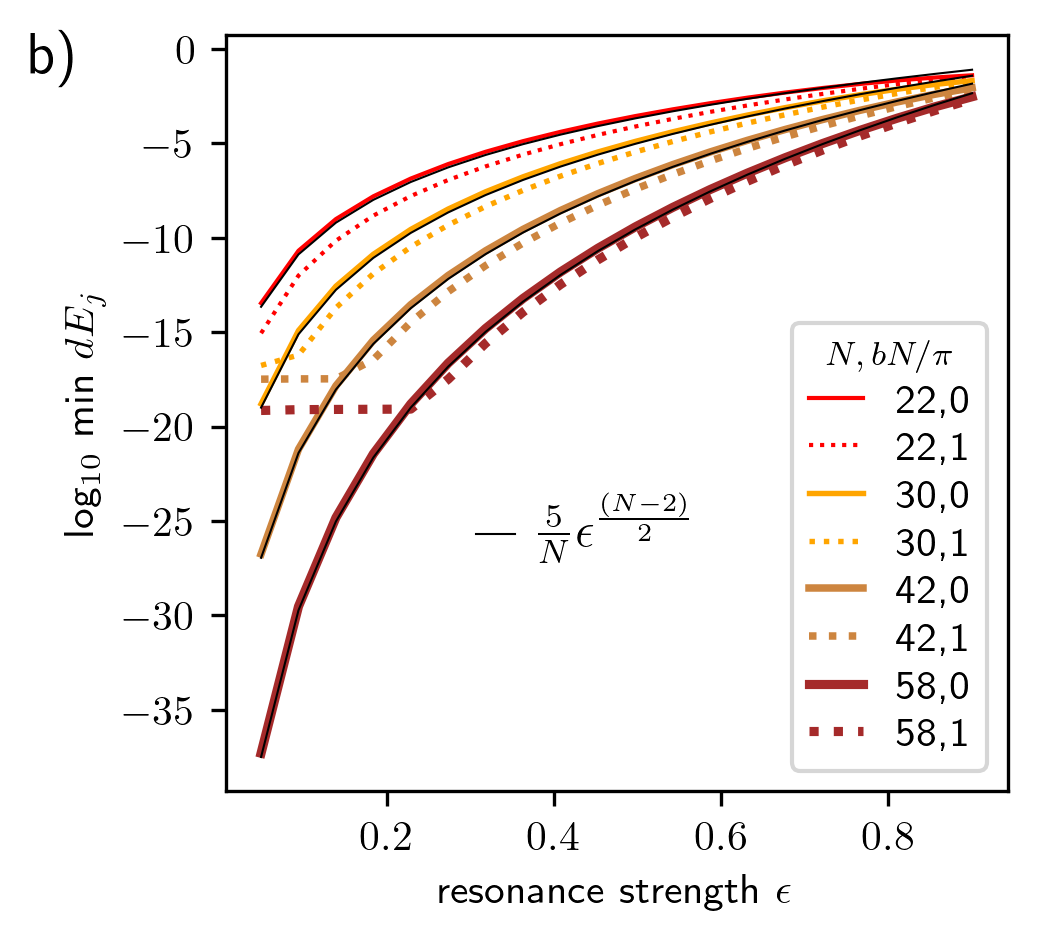

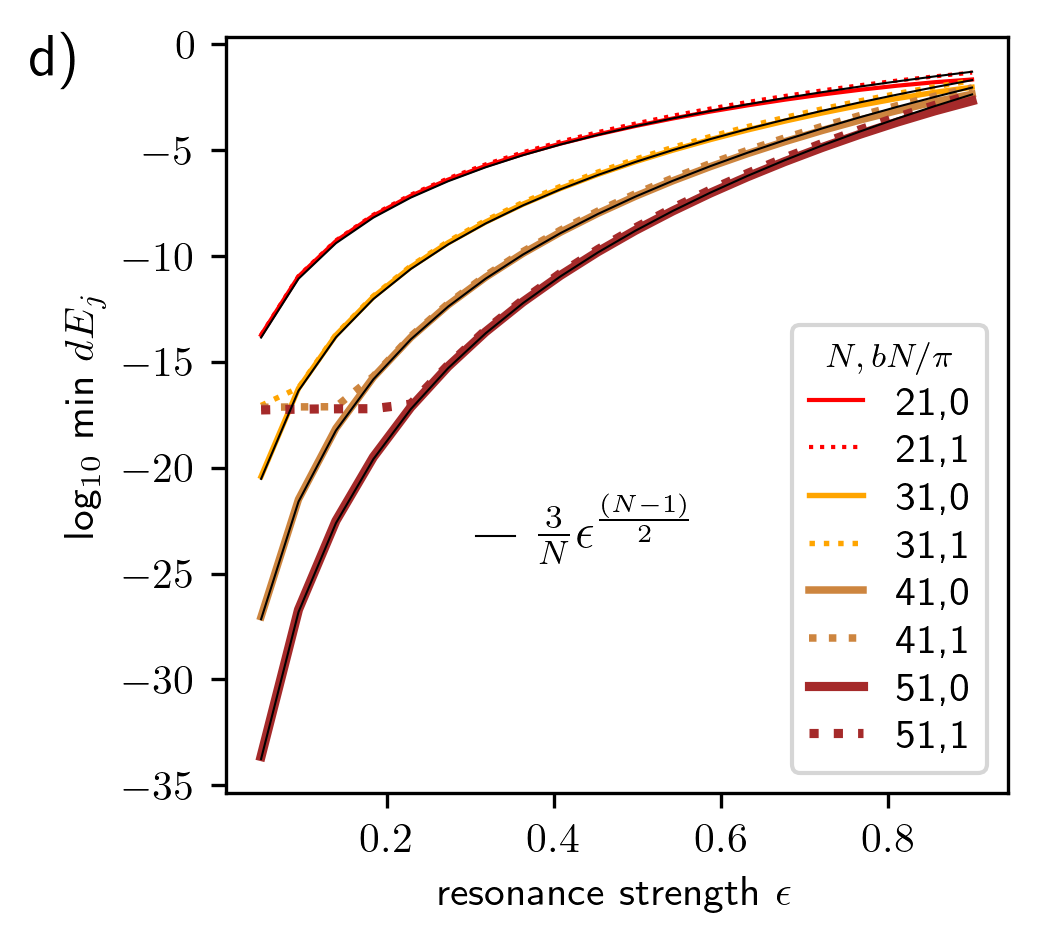

In [28]:
# make figures showing how min spacing depends upon epsilon
def mk_e_fig(nvals,emin1a,emin1c,emin2a,emin2c,emin3a,emin3c,emin4a,emin4c,evals,ntype,ofile):
    color_list = ['red','orange','peru','brown','grey']
    color_list2 = ['indianred','tomato','chocolate','darkred','dimgrey']
    lw_list = np.array([1,1.3,1.8,2.2,2.5])

    fig,ax = plt.subplots(1,1,figsize=(3.3,3),dpi=300)
    plt.subplots_adjust(bottom=0.15, left=0.2, top=0.99, right=0.99)
    handles1 = []
    handles2 = []
    
    k=0; 
    lww,=ax.plot(evals,np.log10(emin1a),'-',label='{:d},0'.format(nvals[k]),lw=lw_list[k],color=color_list[k])
    handles1.append(lww)
    lww,=ax.plot(evals,np.log10(emin1c),':',label='{:d},1'.format(nvals[k]),lw=lw_list[k],color=color_list[k])
    handles1.append(lww)
    
    k=1; 
    lww,=ax.plot(evals,np.log10(emin2a),'-',label='{:d},0'.format(nvals[k]),lw=lw_list[k],color=color_list[k])
    handles1.append(lww)
    lww,=ax.plot(evals,np.log10(emin2c),':',label='{:d},1'.format(nvals[k]),lw=lw_list[k],color=color_list[k])
    handles1.append(lww)
    
    k=2;
    lww,=ax.plot(evals,np.log10(emin3a),'-',label='{:d},0'.format(nvals[k]),lw=lw_list[k],color=color_list[k])
    handles1.append(lww)
    lww,=ax.plot(evals,np.log10(emin3c),':',label='{:d},1'.format(nvals[k]),lw=lw_list[k],color=color_list[k])
    handles1.append(lww)
    
    k=3; 
    lww,=ax.plot(evals,np.log10(emin4a),'-',label='{:d},0'.format(nvals[k]),lw=lw_list[k],color=color_list[k])
    handles1.append(lww)
    lww,=ax.plot(evals,np.log10(emin4c),':',label='{:d},1'.format(nvals[k]),lw=lw_list[k],color=color_list[k])
    handles1.append(lww)

    # show model 
    for k in range(len(nvals)):
        lwm,=ax.plot(evals,etry_fun(evals,nvals[k],ntype),'k-',lw=0.5)

    ax.legend(handlelength=1.3,title=r'$N,bN/\pi$',labelspacing=0.25,title_fontsize=8)
    ax.set_xlabel(r'resonance strength $\epsilon$')
    ylabel = r'log$_{10}$ ' + r'min $dE_j$'
    ax.set_ylabel(ylabel)

    if (ntype == 'even'):
        label =    r'$\frac{5}{N}$'
        label += r'$\epsilon^{\frac{(N-2)}{2}}$' 
        ax.text(-0.25,0.95,'b)',  transform =  ax.transAxes,fontsize=14)
    else:
        label =    r'$\frac{3}{N}$'
        label += r'$\epsilon^{\frac{(N-1)}{2}}$' 
        ax.text(-0.25,0.95,'d)',  transform =  ax.transAxes,fontsize=14)

    ax.plot([0.32,0.37],[0.34,0.34], 'k-', lw=0.5,transform = ax.transAxes)
    ax.text(0.4,0.35,label, transform = ax.transAxes,fontsize=12,va='center') 
    
    plt.savefig(ofile)
    plt.show()

ntype = 'even'
mk_e_fig(neven_vals,eminvals1a,eminvals1c,eminvals2a,eminvals2c,eminvals3a,eminvals3c,eminvals4a,eminvals4c,\
         evalsa,ntype,'even_e.png')
ntype = 'odd'
mk_e_fig(nodd_vals,eminvals1b,eminvals1d,eminvals2b,eminvals2d,eminvals3b,eminvals3d,eminvals4b,eminvals4d,\
         evalsa,ntype,'odd_e.png')

### slice figures 

In [29]:
# compute energy distances for epsilon sweep and a few n values, N even not multiple of 4 
eps_min = 0.1
eps_max = 0.9
n_eps = 9
n1 = 22; n2 = n1+12;  n3 = n2+16  #even values of N not multiple of 4
nvals = np.array([n1,n2,n3],dtype = int)
eps_list1,wlist1a,delist1a = e_de_sweep(eps_min,eps_max,n_eps,0,nvals[0])  # at b=0
eps_list2,wlist2a,delist2a = e_de_sweep(eps_min,eps_max,n_eps,0,nvals[1])
eps_list3,wlist3a,delist3a = e_de_sweep(eps_min,eps_max,n_eps,0,nvals[2])
eps_list1,wlist1b,delist1b = e_de_sweep(eps_min,eps_max,n_eps,1,nvals[0])  # at b=pi/N
eps_list2,wlist2b,delist2b = e_de_sweep(eps_min,eps_max,n_eps,1,nvals[1])
eps_list3,wlist3b,delist3b = e_de_sweep(eps_min,eps_max,n_eps,1,nvals[2])

index1 = np.arange(nvals[0])   # needed for figures below
index2 = np.arange(nvals[1]) 
index3 = np.arange(nvals[2]) 

In [30]:
ee_nvals=np.array([52])  # multiple of 4
ee_eps_list1,ee_wlist1a,ee_delist1a = e_de_sweep(eps_min,eps_max,n_eps,0,ee_nvals[0])  # at b=0
ee_eps_list1,ee_wlist1b,ee_delist1b = e_de_sweep(eps_min,eps_max,n_eps,1,ee_nvals[0])  # at b=pi/N
ee_index1 = np.arange(ee_nvals[0])   

In [31]:
# compute energy distances for epsilon sweep and a few n values,  N-odd 
eps_min = 0.1
eps_max = 0.9
n_eps = 9
n1 = 21; n2 = n1+12;  n3 = n2+16  #odd values of N
onvals = np.array([n1,n2,n3],dtype = int)
oeps_list1,owlist1a,odelist1a = e_de_sweep(eps_min,eps_max,n_eps,0,onvals[0])  # at b=0
oeps_list2,owlist2a,odelist2a = e_de_sweep(eps_min,eps_max,n_eps,0,onvals[1])
oeps_list3,owlist3a,odelist3a = e_de_sweep(eps_min,eps_max,n_eps,0,onvals[2])
oeps_list1,owlist1b,odelist1b = e_de_sweep(eps_min,eps_max,n_eps,1,onvals[0])  # at b=pi/N
oeps_list2,owlist2b,odelist2b = e_de_sweep(eps_min,eps_max,n_eps,1,onvals[1])
oeps_list3,owlist3b,odelist3b = e_de_sweep(eps_min,eps_max,n_eps,1,onvals[2])

oindex1 = np.arange(onvals[0])   # needed for figures below
oindex2 = np.arange(onvals[1]) 
oindex3 = np.arange(onvals[2]) 

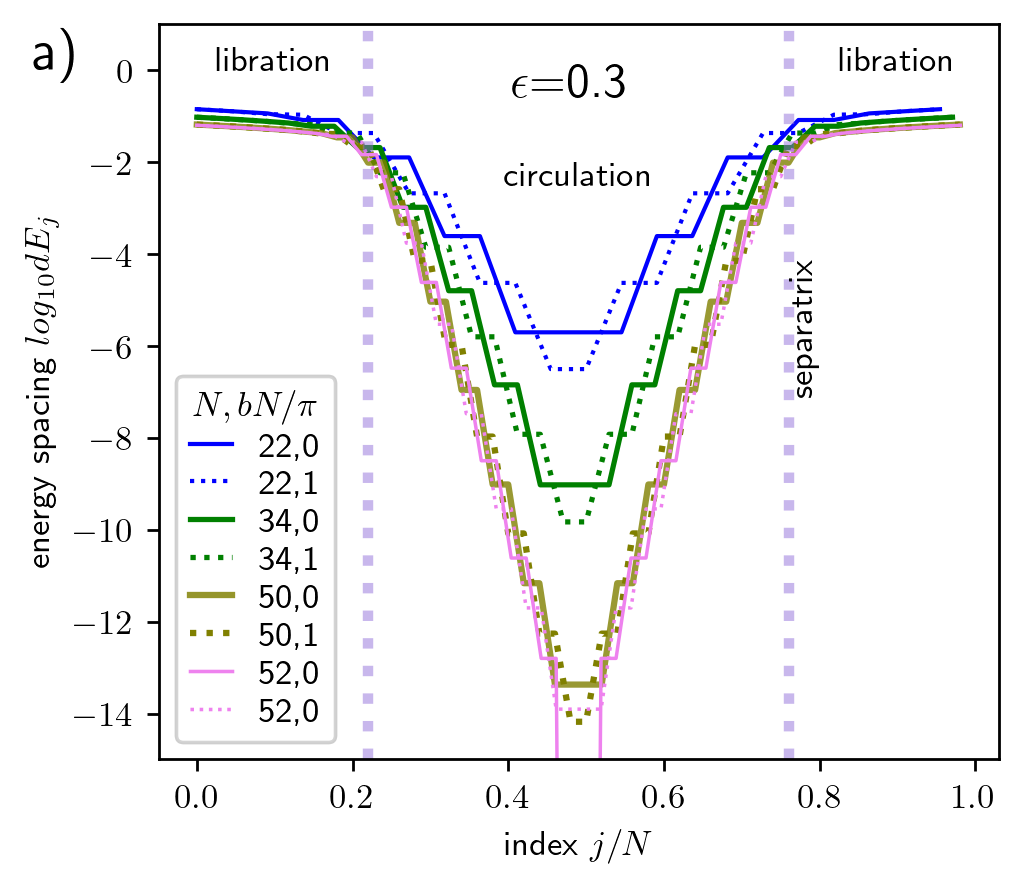

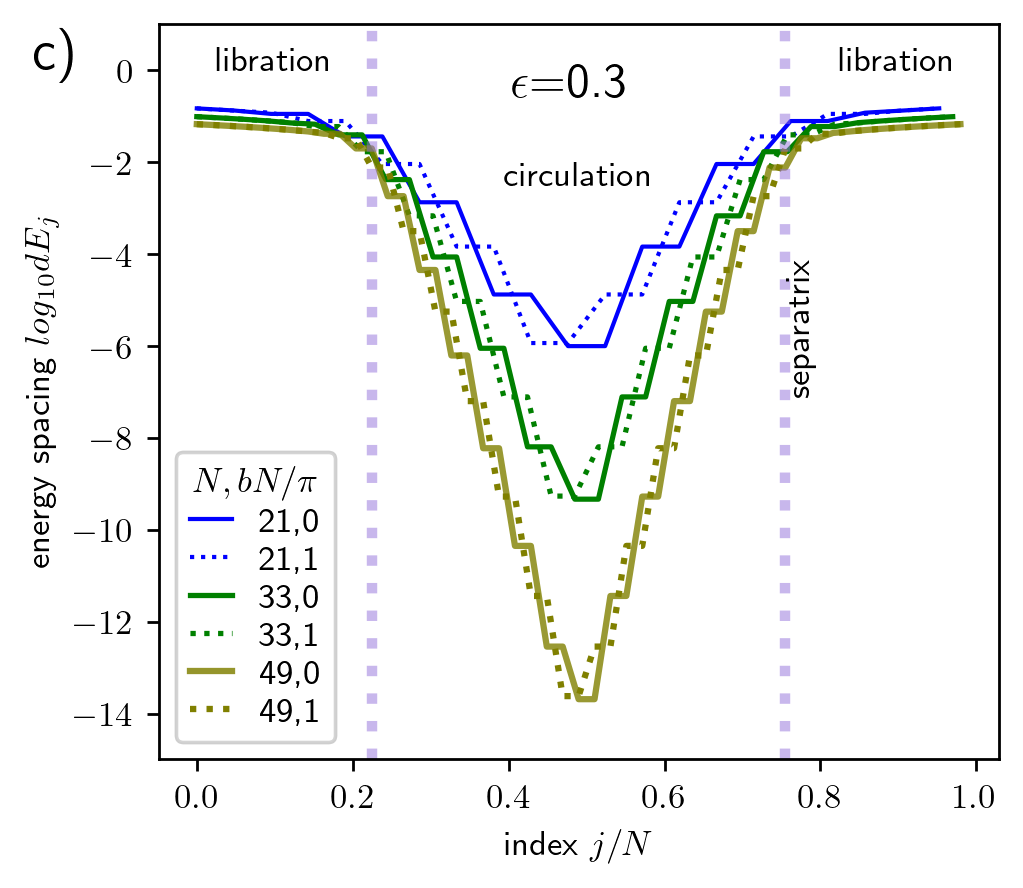

In [32]:
# now make some nice figs 
def mk_fig_slice_n(eps_list1 ,index1, delist1a, delist1b, \
                   eps_list2 ,index2, delist2a, delist2b, \
                   eps_list3 ,index3, delist3a, delist3b, \
                   wlist3b,nvals,ntype,ofile):
    fig, ax = plt.subplots(1,1,figsize=(4,3.5),dpi=250)
    plt.subplots_adjust(left=0.15,right=0.99,bottom=0.15,top=0.99)
    a=1.0; eps  = 0.3  # hard set here!!!!!
    color_list = ['blue','green','olive','violet']
    lw_list = np.array([1.2,1.5,1.8,1])
    handles1 = []
    ax.set_ylim(bottom=-15)

    k=0 
    ii1 = (np.abs(eps_list1 - eps) <0.05); # each has a different N
    lww,= ax.plot(index1/nvals[k],np.log10(delist1a[ii1]),'-',color=color_list[k],label='{:d},0'.format(nvals[k]),lw=lw_list[k])
    handles1.append(lww)
    lww,= ax.plot(index1/nvals[k],np.log10(delist1b[ii1]),':',color=color_list[k],label='{:d},1'.format(nvals[k]),lw=lw_list[k])
    handles1.append(lww)
    ii2 = (np.abs(eps_list2 - eps) <0.05); 
    
    k=1
    lww,= ax.plot(index2/nvals[k],np.log10(delist2a[ii2]),'-',color=color_list[k],label='{:d},0'.format(nvals[k]),lw=lw_list[k])
    handles1.append(lww)
    lww,= ax.plot(index2/nvals[k],np.log10(delist2b[ii2]),':',color=color_list[k],label='{:d},1'.format(nvals[k]),lw=lw_list[k])
    handles1.append(lww)
    ii3 = (np.abs(eps_list3 - eps) <0.05); 
    
    k=2
    lww,= ax.plot(index3/nvals[k],np.log10(delist3a[ii3]),'-',color=color_list[k],label='{:d},0'.format(nvals[k]),lw=lw_list[k],alpha=0.8)
    handles1.append(lww)
    lww,= ax.plot(index3/nvals[k],np.log10(delist3b[ii3]),':',color=color_list[k],label='{:d},1'.format(nvals[k]),lw=lw_list[k])
    handles1.append(lww)
   
    # uses globals: ee_eps_list1, ee_nvals, ee_delist1a, ee_delist1b, ee_index1 
    if (ntype == 'even'):
        ii4 = (np.abs(ee_eps_list1 - eps) <0.05);
        k=0; kc = 3
        lww,= ax.plot(ee_index1/ee_nvals[k],np.log10(ee_delist1a[ii4]),'-',color=color_list[kc],label='{:d},0'.format(ee_nvals[k]),\
                  lw=lw_list[kc])
        handles1.append(lww)
        lww,= ax.plot(ee_index1/ee_nvals[k],np.log10(ee_delist1b[ii4]),':',color=color_list[kc],label='{:d},0'.format(ee_nvals[k]),\
                  lw=lw_list[kc])
        handles1.append(lww)

    first_legend = ax.legend(handles=handles1, loc='lower left',title=r'$N,bN/\pi$',labelspacing=0.2, handlelength=1.2,title_fontsize=10)
    ax.add_artist(first_legend)

    #ax.legend(title=r'$N,bN/\pi$',labelspacing=0.2, handlelength=1.2,title_fontsize=10)
    ax.set_xlabel(r'index $j/N$')
    ax.set_ylabel(r'energy spacing $log_{10} dE_j$')

    # draw separatrices 
    draw_seps=1
    if (draw_seps==1):
        sep_lower = eps -a 
        sep_upper = -1*sep_lower
        ibottom = np.argmin(np.abs(wlist3b[ii3] - sep_lower))/nvals[2]
        itop = np.argmin(np.abs(wlist3b[ii3] - sep_upper))/nvals[2]
        # draw seps
        ymin,ymax = ax.get_ylim()
        sepcolor = 'mediumpurple'
        ax.plot([itop,itop],[ymin,ymax],':', alpha=0.5,lw=3,color=sepcolor)
        ax.plot([ibottom,ibottom],[ymin,ymax],':', alpha=0.5,lw=3,color=sepcolor)
        ax.text(itop,(ymin+ymax)/2, 'separatrix', rotation=90,ha='left');

    if (ntype=='even'):
        ax.text(-0.15,0.94,'a)',fontsize=16,transform = ax.transAxes)
    else:
        ax.text(-0.15,0.94,'c)',fontsize=16,transform = ax.transAxes)
        
    ax.text(0.49,0.9,r'$\epsilon$={:.1f}'.format(eps),ha = 'center',transform =  ax.transAxes,fontsize=14)

    ax.text(0.1,0.0,'libration',ha='center')#, transform = ax.transAxes)
    ax.text(0.9,0.0,'libration',ha='center')#, transform = ax.transAxes,ha='center')
    ax.text(0.49,-2.5,'circulation',ha='center')#, transform = ax.transAxes,ha='center')

    plt.savefig(ofile)
    plt.show()

    show_model=0  # set this to 1 if you want to explore models 
    if (show_model==1):  # plot models
    #labels = []
        handles2 = []
        for k in range(len(nvals)):
            fraction,z = de_model(nvals[k],eps,'even')
            lww, = ax.plot(fraction - 0.5/nvals[k],np.log10(z),'-',color=color_list[k], lw=lw_list[k]/2, label = "{:d}".format(nvals[k]))
            handles2.append(lww)
        
        second_legend = ax.legend(handles=handles2, loc='lower right',labelspacing=0.2, \
                              handlelength=1.2,title_fontsize=10,title=r'model $N$')

#ax.legend()
#print(labels)

ntype = 'even'
mk_fig_slice_n(eps_list1,index1,delist1a,delist1b,\
               eps_list2,index2,delist2a,delist2b,\
               eps_list3,index3,delist3a,delist3b,\
               wlist3b,nvals,ntype,'nslice.png')

ntype = 'odd'
mk_fig_slice_n(oeps_list1,oindex1,odelist1a,odelist1b,\
               oeps_list2,oindex2,odelist2a,odelist2b,\
               oeps_list3,oindex3,odelist3a,odelist3b,\
               owlist3b,onvals,ntype,'onslice.png')

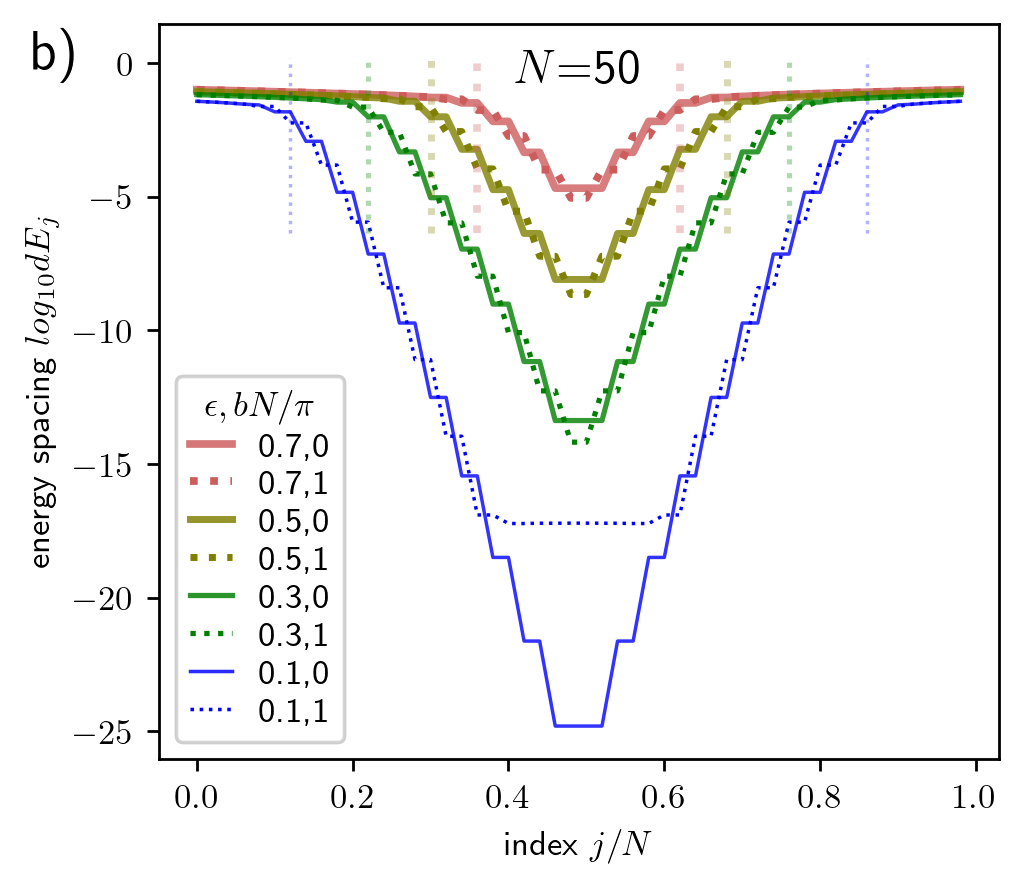

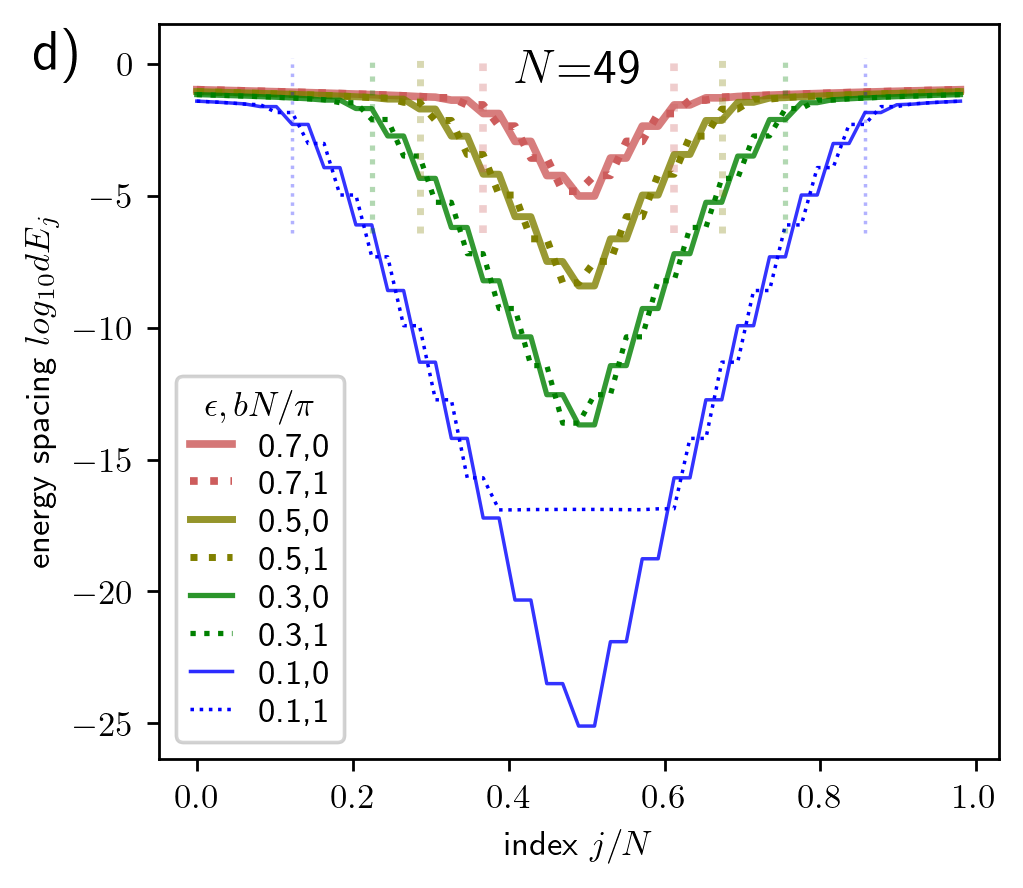

In [33]:
# slices with different epsilon instead of different N
def mk_fig_slice_3(eps_list3,index3,delist3a,delist3b,wlist3b,nvals,ntype,ofile):
    fig, ax = plt.subplots(1,1,figsize=(4,3.5),dpi=250)
    plt.subplots_adjust(left=0.15,right=0.99,bottom=0.15,top=0.99)
    a=1.0; 
    color_list = ['indianred','olive','green','blue']
    lw_list = np.array([2.2,2,1.5,1])
    epsvals = np.array([0.7,0.5,0.3,0.1])
    handles1 = []
    for k in range(len(epsvals)):
        eps  = epsvals[k]; elab0 = '{:.1f},0'.format(eps); elab1 = '{:.1f},1'.format(eps);
        ii = (np.abs(eps_list3 - eps) <0.05)
        lww,=ax.plot(index3/nvals[2],np.log10(delist3a[ii]),'-',color=color_list[k],label=elab0,lw=lw_list[k],alpha=0.8)
        handles1.append(lww)
        lww,=ax.plot(index3/nvals[2],np.log10(delist3b[ii]),':' ,color=color_list[k],label=elab1,lw=lw_list[k])
        handles1.append(lww)

    first_legend = ax.legend(handles=handles1, loc='lower left',title=r'$\epsilon,bN/\pi$',labelspacing=0.2, \
                             handlelength=1.2,title_fontsize=10)
    ax.add_artist(first_legend)

    #ax.legend(title=r'$\epsilon,bN/\pi$',labelspacing=0.2, handlelength=1.2,title_fontsize=10)
    ax.set_xlabel(r'index $j/N$')
    ax.set_ylabel(r'energy spacing $log_{10} dE_j$')

    if (ntype=='even'):
        ax.text(-0.15,0.94,'b)',fontsize=16,transform =  ax.transAxes)
    else:
        ax.text(-0.15,0.94,'d)',fontsize=16,transform =  ax.transAxes)
        
    ax.text(0.5,0.92,r'$N$={:d}'.format(nvals[2]),ha = 'center',transform =  ax.transAxes,fontsize=14)

    # draw separatrices 
    draw_seps=1
    if (draw_seps ==1):
        ymin,ymax = ax.get_ylim()
        dy = ymax-ymin
        ymin_h = ymax - dy/4
        for k in range(len(epsvals)):
            eps  = epsvals[k]
            ii3 = (np.abs(eps_list3 - eps) <0.05); # each different eps has a different sep location 
            sep_lower = eps -a 
            sep_upper = -1*sep_lower
            # find closest energy!!!!!!!!!!!
            ibottom = np.argmin(np.abs(wlist3b[ii3] - sep_lower))/nvals[2]  # energy near sep energy!
            itop = np.argmin(np.abs(wlist3b[ii3] - sep_upper))/nvals[2]
            # draw seps
            ax.plot([itop,itop],[ymin_h,ymax],':', alpha=0.3,lw=lw_list[k],color=color_list[k])
            ax.plot([ibottom,ibottom],[ymin_h,ymax],':', alpha=0.3,lw=lw_list[k],color=color_list[k])

    plt.savefig(ofile)
    plt.show()

    show_model = 0
    if (show_model==1):  # draw models 
        handles2 = []
        for k in range(len(epsvals)):
            fraction,z = de_model(nvals[2],epsvals[k],'even')
            lww, = ax.plot(fraction - 0.5/nvals[2],np.log10(z),'-',color=color_list[k], lw=lw_list[k]/2,label='{:.1f}'.format(epsvals[k]))
            handles2.append(lww)
        second_legend = ax.legend(handles=handles2, loc='lower right',labelspacing=0.2, handlelength=1.2,\
                                  title_fontsize=10, title=r'model $\epsilon$')


ntype='even'
mk_fig_slice_3(eps_list3,index3,delist3a,delist3b,wlist3b,nvals,ntype,'eslice.png')

ntype='odd'
mk_fig_slice_3(oeps_list3,oindex3,odelist3a,odelist3b,owlist3b,onvals,ntype,'oeslice.png')

### looking at mathieu function 

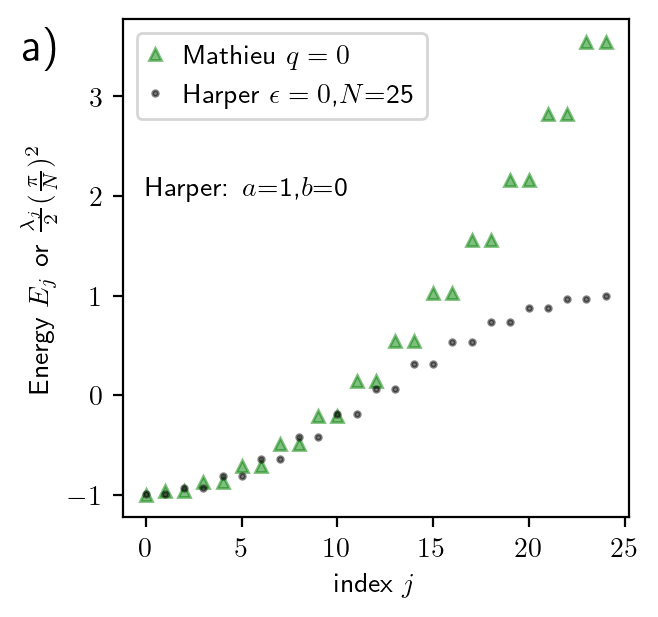

In [34]:

#scipy.special.mathieu_a # mathieu_a(m, q, ... 
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.mathieu_a.html
#scipy.special.mathieu_b
from scipy.special import mathieu_a
from scipy.special import mathieu_b


# We mash the characteristics of the Mathieu equation together and then sort them 
def c_mathieu2(rmax,q,N):
    fac = (1/2)*(np.pi/N)**2  # notice this factor!!!! converting to energies that can be compared to Harper model
    # we only care about even 
    mvalsa = np.arange(0,rmax,2)  # only even indices starting from 0, 
    aar = fac*mathieu_a(mvalsa,q) # These are characteristics of even Mathieu eigenfuns 
    mvalsb = np.arange(2,rmax,2)  # only even incides starting from 2  
    bbr = fac*mathieu_b(mvalsb,q) # These are characteristics of odd Mathieu eigenfuns
    mix = np.append(aar,bbr)  # mash together into a single array 
    sort_mix = np.sort(mix)  # short them 
    index_k = np.arange(len(sort_mix))  # also include a list of indices so can easily plot them
    return sort_mix, index_k

# lets start by checking eps = 0
n=25
rmax=n
sort_mix, index_k = c_mathieu2(rmax,0.0,n)  # compute eigenvalues of mathieu function 
wlist1, vr1 = h0_prec_eigs(n,1,0,0)  # compute eigenvalues of Harper op
index_n = np.arange(n)

# compare the two sets, as epsion is zero, there should be degeneracies in pairs
fig, ax = plt.subplots(1,1,figsize=(3.2,3), dpi=200)
plt.subplots_adjust(left=0.2,top=0.98,right=0.99,bottom=0.15)
mlabel = r'Mathieu $q=0$'
ax.plot(index_k,sort_mix-1,'g^',ms=4,alpha=0.5,label=mlabel) # subtracting 1 
hlabel = r'Harper $\epsilon=0$,$N$={:d}'.format(n)
ax.plot(index_n,wlist1,'ko',ms=2,alpha=0.5,label=hlabel)
ax.set_xlabel(r'index $j$')
ylab = r'Energy $E_j$ or $\frac{\lambda_j}{2}(\frac{\pi}{N})^2$'
ax.set_ylabel(ylab)
ax.legend(handlelength=0.5)
ax.text(-0.2,0.92,'a)', transform =  ax.transAxes,fontsize=16)
ax.text(-0.0,2,'Harper: $a$=1,$b$=0')

plt.savefig('Mathieu1.png')  
plt.show()   # this looks ok at the bottom

q 101.32118364233777


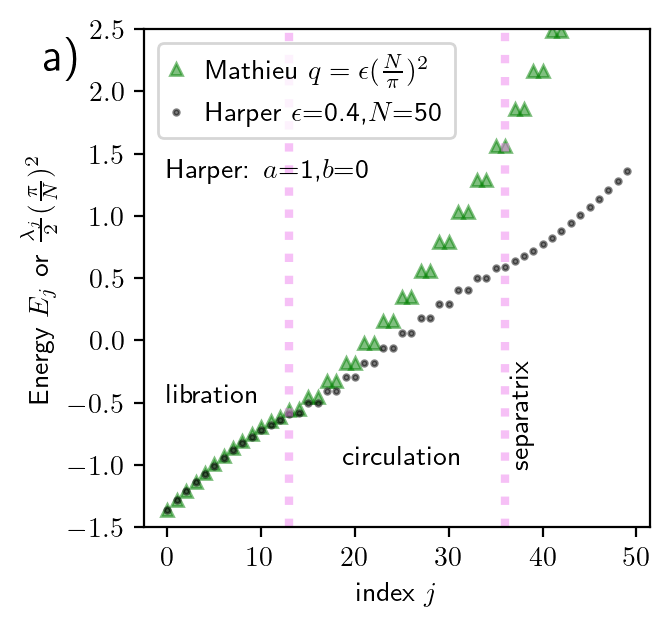

In [35]:
# how let's look at nonzero eps 
n=50
rmax=n
eps = 0.4
q = (1.)*eps*(n/np.pi)**2
print('q',q)
sort_mix, index_k = c_mathieu2(rmax,q,n)
#cvals2 = c_mathieu(rmax,q,n)
wlist, vr = h0_prec_eigs(n,1,0,eps)
index_n = np.arange(n)
dvals2 = sort_mix - sort_mix[0] + wlist[0]

fig, ax = plt.subplots(1,1,figsize=(3.2,3), dpi=200)
plt.subplots_adjust(left=0.2,top=0.98,right=0.99,bottom=0.15)
epslabel = r'$\epsilon$={:.1f}'.format(eps) 
epslabel += r',$N$={:d}'.format(n)
qlabel = r'$q=\epsilon ( \frac{N}{\pi} )^2$'
ax.plot(index_k,dvals2,'g^',ms=4,alpha=0.5,label='Mathieu ' + qlabel)
ax.plot(index_n,wlist,'ko',ms=2,alpha=0.5,label='Harper '+ epslabel)
ax.set_xlabel(r'index $j$')
ylab = r'Energy $E_j$ or $\frac{\lambda_j}{2}(\frac{\pi}{N})^2$'
ax.set_ylabel(ylab)
ax.legend(handlelength=0.5)
ax.set_ylim([-1-eps-0.1,2.5])
ax.text(-0.0,1.3,'Harper: $a$=1,$b$=0')
ax.text(-0.2,0.92,'a)', transform =  ax.transAxes,fontsize=16)

# find separatrix and plot it
ymin,ymax = ax.get_ylim()
sep_up = 1-eps
sep_dn = -sep_up
ii = np.argmin(np.abs(wlist - sep_dn))
ax.plot([ii,ii],[ymin,ymax],':',color='violet',alpha=0.5,lw=3)
ii = np.argmin(np.abs(wlist - sep_up))
ax.plot([ii,ii],[ymin,ymax],':',color='violet',alpha=0.5,lw=3)
ax.text(ii+0.5,-1,'separatrix',rotation=90)
ax.text(n/2,-1,'circulation',ha='center')
ax.text(5,-0.5,'libration',ha='center')

# need to draw the separatrix!!!!! and label circulating and libration regions 
 
plt.savefig('Mathieu2.png')    
plt.show() 

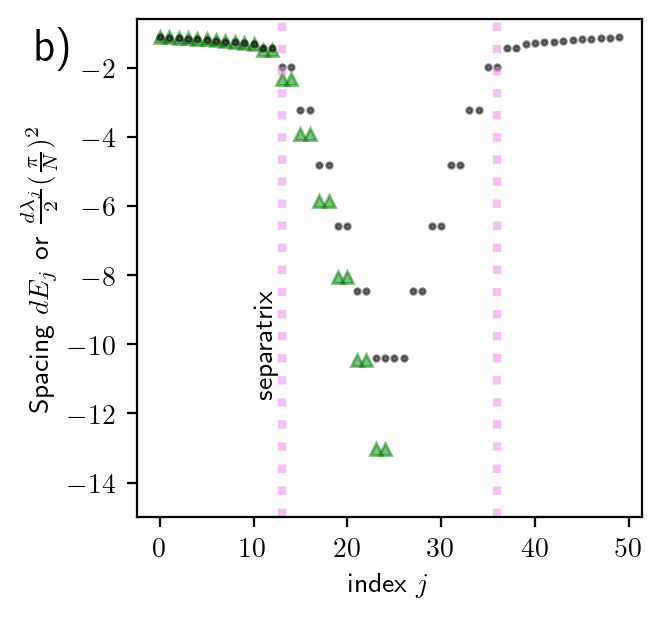

In [36]:
# how let's look at nonzero eps , diffs

fig, ax = plt.subplots(1,1,figsize=(3.2,3), dpi=200)
plt.subplots_adjust(left=0.2,top=0.98,right=0.99,bottom=0.15)

n=50
rmax=n
eps = 0.4
q = (1.)*eps*(n/np.pi)**2
#print('q',q)
sort_mix, index_k = c_mathieu2(rmax,q,n)
#cvals2 = c_mathieu(rmax,q,n)
wlist, vr = h0_prec_eigs(n,1,0,eps)
index_n = np.arange(n)
dvals = sort_mix - sort_mix[0] + wlist[0]

dEj = min_de_vec(wlist)
dMj = min_de_vec(dvals)
ax.plot(index_k,np.log10(dMj + 1e-20),'g^',ms=4,alpha=0.5,label='Mathieu ' + qlabel)
ax.plot(index_n,np.log10(dEj),'ko',ms=2,alpha=0.5,label='Harper '+ epslabel)

epslabel = r'$\epsilon$={:.1f}'.format(eps) 
epslabel += r',$N$={:d}'.format(n)
qlabel = r'$q=\epsilon ( \frac{N}{\pi} )^2$'
ax.set_xlabel(r'index $j$')
ylab = r'Spacing $dE_j$ or $\frac{d\lambda_j}{2}(\frac{\pi}{N})^2$'
ax.set_ylabel(ylab)
#ax.legend(handlelength=0.5,labelspacing=0.2,loc='upper right')
ax.set_ylim([-15,-0.6])
#ax.text(-0.1,0.1,'Harper: $a$=1,$b$=0',transform =  ax.transAxes,fontsize=12)
ax.text(-0.2,0.92,'b)', transform =  ax.transAxes,fontsize=16)

# find separatrix and plot it
ymin,ymax = ax.get_ylim()
sep_up = 1-eps
sep_dn = -sep_up
ii = np.argmin(np.abs(wlist - sep_dn))
ax.plot([ii,ii],[ymin,ymax],':',color='violet',alpha=0.5,lw=3)
ax.text(ii-3,-10,'separatrix',rotation=90,va='center')
ii = np.argmin(np.abs(wlist - sep_up))
ax.plot([ii,ii],[ymin,ymax],':',color='violet',alpha=0.5,lw=3)

#ax.text(n/2,-1,'circulation',ha='center')
#ax.text(5,-0.5,'libration',ha='center')
 
plt.savefig('Mathieu3.png')    
plt.show() 

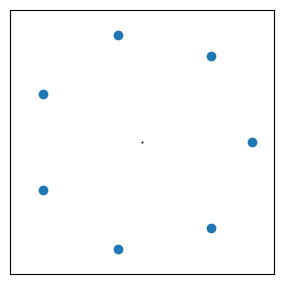

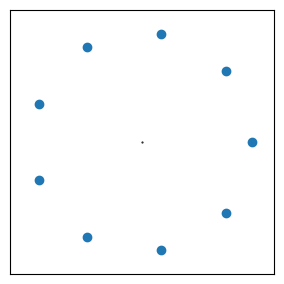

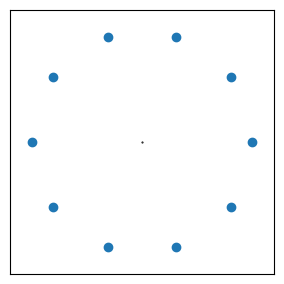

In [61]:
# this was useful for making inkscape illustrations of roots of unity
def plt_circ(N,ofile):
    fig,ax = plt.subplots(1,1,figsize=(3,3))
    plt.subplots_adjust(bottom=0.1,top=0.98,right=0.99,left=0.1)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    karr = np.arange(N)
    x = np.cos(2*np.pi*karr/N)
    y = np.sin(2*np.pi*karr/N)
    ax.plot(x,y,'o')
    xmax = 1.2
    ax.set_xlim([-xmax,xmax])
    ax.set_ylim([-xmax,xmax])
    ax.plot([0],[0],'k.',ms=1)
    if (len(ofile)>3):
        plt.savefig(ofile)
    plt.show()

plt_circ(7,'c7.png')
plt_circ(9,'c9.png')
plt_circ(10,'c10.png')

In [ ]:
# dead below

In [614]:
# a function that is supposed to give distance to separatrix as a fraction 
# as a function of epsilon 
def fit_fun2(x,a,b):  # x is epsilon, a,b are free parameters 
    z = x/2 + a*x*(1-x) + b*x*x*(1-x)   #+ d*np.sin(2*x/np.pi) +   +  b*np.sin(x/np.pi)
    return z

# trying to model the shape
# this is convoluted and stupid, could be fixed but seems kind of senseless
def de_model(n,eps,ntype):
    a=1.0 
    flat = np.sqrt(a*eps)*(2*np.pi/n)  
    # spacing = hbar omega_0 with hbar = 2pi/N and omega_0 = sqrt(a eps)
    # this is the energy diff at the top, based on a harmonic oscillator at the bottom of the potential well
    # good for all values of n

    if (ntype=='even'):
        bottom = eps**((n-2)/2) * 5/n  # depth guess for even N  (not a mult of 4)
    else:
        bottom = eps**((n-1)/2) * 3/n  # depth guess for N odd
    
    fraction = np.linspace(0,1,100)
    vfraction = np.fmin(fraction, 1-fraction) # goes to 1/2 in the middle 
    popt = np.array([ 0.59654194, -0.75907468]) # result of fit below 
    f_sep = fit_fun2(eps,*popt)
    d_sep = 0.5 - f_sep # distance of sep from center in units of fraction which spans 0 to 1 

    zz = 0 * fraction 
    k_circ = vfraction >= f_sep  # in circulating region 
    k_lib = vfraction < f_sep  # in librating region 
    zz[k_lib] = flat   # is flat in libration region 
    
    aa  = -np.log10(bottom/flat)/d_sep
    vs_fraction = vfraction - f_sep   # should be zero at both seps and gives distance to sep from center
    # this is the result in circulation region 
    zz[k_circ]= flat*np.power(10,-vs_fraction[k_circ]*aa)   # this is just a power law (dE/de)^j/js where j is 0 at center of circulation

    if (1==0):  # try a plot
        fig, ax = plt.subplots(1,1,figsize=(4,3.5),dpi=250)
        plt.subplots_adjust(left=0.15,right=0.99,bottom=0.15,top=0.99)
        ax.plot(fraction,np.log10(zz))
        #ax.plot(fraction,vfraction)
        #junk = f_sep + 0*fraction 
        #ax.plot(fraction,junk)
        #ax.plot(fraction[k_circ],junk[k_circ],'k-')
        #ax.plot(fraction[k_lib],junk[k_lib],'r.')
        plt.show()
        
    return fraction, zz


# testing
#n= 41; eps = 0.5 
#f,z=de_model(n,eps)


# we need to find the distance to the separatrix in index 
def find_sep(n):
    eps_lin = np.linspace(0.05,0.95,15) # for each epsilon in this list 
    f_sep_arr = eps_lin*0
    #n = 62
    for k in range(len(eps_lin)):
        eps = eps_lin[k]
        (w,vr)= h0_prec_eigs(n,mpmath.mpf(1),mpmath.mpf(0),mpmath.mpf(eps))   # n a b eps
        sep_up = eps - 1.
        ii = np.argmin(np.abs(w-sep_up)) /n  # find index of closest energy to sep 
        f_sep_arr[k] = ii

    # fit a function to it
    eps_lin2 = np.concatenate((np.zeros(1),eps_lin,np.zeros(1) + 1))
    f_sep_arr2 = np.concatenate((np.zeros(1),f_sep_arr,np.zeros(1) + 0.5))
    popt,pcov = curve_fit(fit_fun2, eps_lin2, f_sep_arr2,p0=np.zeros(2))   
    elin = np.linspace(0,1,100)
    popt_fit = fit_fun2(elin,*popt)
    print(popt)
    return eps_lin2,f_sep_arr2,elin,popt_fit,popt 



In [616]:
# find the fit parameters, this takes a while
eps_lin_a,f_sep_arr_a,elin_a,popt_fit_a,popt_a  = find_sep(62) #
eps_lin_b,f_sep_arr_b,elin_b,popt_fit_b,popt_b  = find_sep(42) #
# here are the fit params

[ 0.59654194 -0.75907468]
[ 0.56974259 -0.80041228]


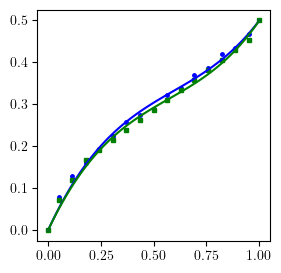

In [619]:
fig,ax = plt.subplots(1,1,figsize=(3,3))
ax.plot(eps_lin_a,f_sep_arr_a,'b.',ms=5)
ax.plot(eps_lin_b,f_sep_arr_b,'gs',ms=3)
ax.plot(elin_a,popt_fit_a,'b-')
ax.plot(elin_b,popt_fit_b,'g-')
plt.show()

In [ ]:
# not too strong a function of n 


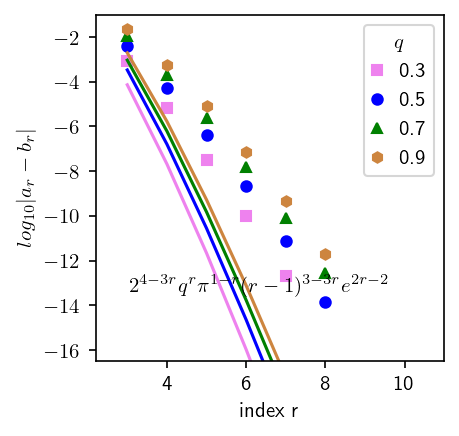

In [504]:

#Let's look at diffs between Mathieu function eigenvalues!

def diff_math(r,q):
    z= 100*q**(r+0)/r**(r-1.) * np.exp(-(2*r))
    label =  r'$100\frac{q^r}{r^{r-1}}$'
    label += r'$e^{-2r}$' 
    #z = (q)**(r+0)/r**(r-1.) / np.power(2,2*r+2)
    #label = r'$q^r r^{1-r} 2^{-2r}$'
    m = r
    z = 2.0**(4.0-3*m) * q**m * np.pi**(1.-m) * (r-1.0)**(3-3*m) * np.exp(2*m-2) 
    label = r'$2^{4-3r}  q^r \pi^{1-r} (r-1)^{3-3r} e^{2r-2}$'
    return z,label 

fig,ax = plt.subplots(1,1,figsize=(3,3),dpi=150)
ax.set_ylim(bottom = -16.5,top=-1)
ax.set_xlim(left=2.2,right=11.)
color_list = ['violet','blue','green','peru']
mtype = ['s','o','^','h']

qvals = np.array([0.3,0.5,0.7,0.9])
rmin = 3; rmax=12
for k in range(len(qvals)):
    abdif,rlist = dab_mathieu(rmin,rmax,qvals[k])
    ax.plot(rlist,np.log10(abdif + 1e-30),mtype[k],color=color_list[k],label='{:.1f}'.format(qvals[k]),ms=5)
    mod,label = diff_math(rlist,qvals[k])
    ax.plot(rlist,np.log10(mod + 1e-30), '-', color=color_list[k])
ax.set_xlabel('index r')
ax.legend(title=r'$q$',handlelength=0.5)
ax.set_ylabel(r'$log_{10} |a_r - b_r|$')
xticks = np.arange(4, rmax, 2)
xlabels = [f'{x:1.0f}' for x in xticks]
ax.set_xticks(xticks, labels=xlabels)
#label =  r'$100\frac{q^r}{r^{r-1}}$'
#label += r'$e^{-2r}$' 
ax.text(0.1,0.2,label, transform =  ax.transAxes,fontsize=10) 

plt.show()

### checking determinants

In [572]:
# let's look at the det again 
eps_vals = np.array([0.0,0.1,0.3,0.5,0.7,0.9])
d_arr1 = []
d_arr2 = []
d_arr3 = []
envals = np.array([22,22+12,22+12+16], dtype=int)
for k in range(len(eps_vals)):
    n = envals[0]
    tn = mpmath.power(2,n)  # this is 2^n and automatically converts arguments to mpf
    z = mpmath.re(h0_prec_det(n,1.0,0.0,eps_vals[k]))
    z = mpmath.fmul(z,tn)
    d_arr1 = np.append(d_arr1,z)

    n = envals[1]
    tn = mpmath.power(2,n)  # this is 2^n and automatically converts arguments to mpf
    z = mpmath.re(h0_prec_det(n,1.0,0.0,eps_vals[k]))
    z = mpmath.fmul(z,tn)
    d_arr2 = np.append(d_arr2,z)

    n = envals[2]
    tn = mpmath.power(2,n)  # this is 2^n and automatically converts arguments to mpf
    z = mpmath.re(h0_prec_det(n,1.0,0.0,eps_vals[k]))
    z = mpmath.fmul(z,tn)
    d_arr3 = np.append(d_arr3,z)

d_arr1 = np.array(d_arr1,dtype=float)
d_arr2 = np.array(d_arr2,dtype=float)
d_arr3 = np.array(d_arr3,dtype=float)

nvals = np.arange(6,42,4)
nd_arr0 = []
nd_arr1 = []
nd_arr2 = []
nd_arr3 = []
nd_arr4 = []
nd_arr5 = []
for k in range(len(nvals)):
    n = nvals[k]
    tn = mpmath.power(2,n)  # this is 2^n and automatically converts arguments to mpf
    z = mpmath.fmul(mpmath.re(h0_prec_det(n,1.0,0.0,eps_vals[0])),tn)
    nd_arr0 = np.append(nd_arr0,z)
    z = mpmath.fmul(mpmath.re(h0_prec_det(n,1.0,0.0,eps_vals[1])),tn)
    nd_arr1 = np.append(nd_arr1,z)
    z = mpmath.fmul(mpmath.re(h0_prec_det(n,1.0,0.0,eps_vals[2])),tn)
    nd_arr2 = np.append(nd_arr2,z)
    z = mpmath.fmul(mpmath.re(h0_prec_det(n,1.0,0.0,eps_vals[3])),tn)
    nd_arr3 = np.append(nd_arr3,z)
    z = mpmath.fmul(mpmath.re(h0_prec_det(n,1.0,0.0,eps_vals[4])),tn)
    nd_arr4 = np.append(nd_arr4,z)
    z = mpmath.fmul(mpmath.re(h0_prec_det(n,1.0,0.0,eps_vals[5])),tn)
    nd_arr5 = np.append(nd_arr5,z)

#print (nd_arr1)

nd_arr0 = np.array(nd_arr0,dtype=float)
nd_arr1 = np.array(nd_arr1,dtype=float)
nd_arr2 = np.array(nd_arr2,dtype=float)
nd_arr3 = np.array(nd_arr3,dtype=float)
nd_arr4 = np.array(nd_arr4,dtype=float)
nd_arr5 = np.array(nd_arr5,dtype=float)


onvals = np.arange(5,42,2)
ond_arr0 = []
ond_arr1 = []
ond_arr2 = []
ond_arr3 = []
ond_arr4 = []
ond_arr5 = []
for k in range(len(onvals)):
    n = onvals[k]
    tn = mpmath.power(2,n)  # this is 2^n and automatically converts arguments to mpf
    z = mpmath.fmul(mpmath.re(h0_prec_det(n,1.0,0.0,eps_vals[0])),tn)
    ond_arr0 = np.append(ond_arr0,z)
    z = mpmath.fmul(mpmath.re(h0_prec_det(n,1.0,0.0,eps_vals[1])),tn)
    ond_arr1 = np.append(ond_arr1,z)
    z = mpmath.fmul(mpmath.re(h0_prec_det(n,1.0,0.0,eps_vals[2])),tn)
    ond_arr2 = np.append(ond_arr2,z)
    z = mpmath.fmul(mpmath.re(h0_prec_det(n,1.0,0.0,eps_vals[3])),tn)
    ond_arr3 = np.append(ond_arr3,z)
    z = mpmath.fmul(mpmath.re(h0_prec_det(n,1.0,0.0,eps_vals[4])),tn)
    ond_arr4 = np.append(ond_arr4,z)
    z = mpmath.fmul(mpmath.re(h0_prec_det(n,1.0,0.0,eps_vals[5])),tn)
    ond_arr5 = np.append(ond_arr5,z)

ond_arr0 = np.array(ond_arr0,dtype=float)
ond_arr1 = np.array(ond_arr1,dtype=float)
ond_arr2 = np.array(ond_arr2,dtype=float)
ond_arr3 = np.array(ond_arr3,dtype=float)
ond_arr4 = np.array(ond_arr4,dtype=float)
ond_arr5 = np.array(ond_arr5,dtype=float)

numerically I find that 

$\det \hat h(a,0,\epsilon) = -2^{2-N}(1 + \epsilon^n) \text{ for } N \text{ mod } 4 = 2$

$\det \hat h(a,0,\epsilon) = 2^{1-N}(1 + \epsilon^n) \text{ for } N \text{ odd }$

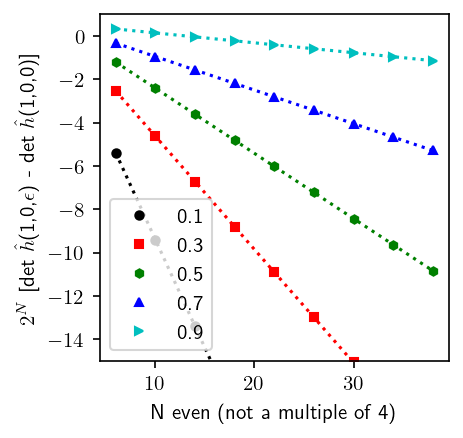

In [588]:
def dumfun(n,eps):
    return 4*eps**(n)   # since I multiplied by 2^n  previously 
    # this means that det h = 2^(2-n) + 4 epsilon^n 2^-n for n even, not multiple of 4
    # this is equal to 2^(2-n)(1 + \epsilon^n)

fig,ax = plt.subplots(1,1,figsize=(3,3),dpi=150)
ax.set_ylim(bottom=-15)
#ax.plot(nvals,np.log10(np.fabs(nd_arr1)), '.')
#ax.plot(nvals,np.log10(np.fabs(nd_arr2)), '.')
minval = 1e-20
ax.plot(nvals,np.log10(np.fabs(nd_arr1- nd_arr0)+ minval), 'ko',label='{:.1f}'.format(eps_vals[1]),ms=4)
ax.plot(nvals,np.log10(np.fabs(nd_arr2- nd_arr0)+ minval), 'rs',label='{:.1f}'.format(eps_vals[2]),ms=4)
ax.plot(nvals,np.log10(np.fabs(nd_arr3- nd_arr0)+ minval), 'gh',label='{:.1f}'.format(eps_vals[3]),ms=4)
ax.plot(nvals,np.log10(np.fabs(nd_arr4- nd_arr0)+ minval), 'b^',label='{:.1f}'.format(eps_vals[4]),ms=4)
ax.plot(nvals,np.log10(np.fabs(nd_arr5- nd_arr0)+ minval), 'c>',label='{:.1f}'.format(eps_vals[5]),ms=4)
nv = np.linspace(min(nvals),max(nvals),100)
ax.plot(nv,np.log10(dumfun(nv,eps_vals[1])),'k:')
ax.plot(nv,np.log10(dumfun(nv,eps_vals[2])),'r:')
ax.plot(nv,np.log10(dumfun(nv,eps_vals[3])),'g:')
ax.plot(nv,np.log10(dumfun(nv,eps_vals[4])),'b:')
ax.plot(nv,np.log10(dumfun(nv,eps_vals[5])),'c:')
ax.legend()
ax.set_xlabel(r'$N$ even (not a multiple of 4)')
ax.set_ylabel(r'$2^N$ [det $\hat h$(1,0,$\epsilon$) - det $\hat h$(1,0,0)]')             
plt.show()

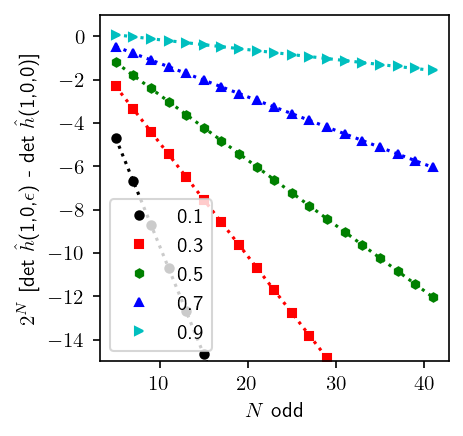

In [589]:
def dumfun2(n,eps):
    return 2*eps**(n)   # since I multiplied by 2^n  previously 
    # this means that det h = 2^(2-n) - 4 epsilon^n 2^-n for n even, not multiple of 4
    # this is equal to -2^(1-n)(1 + \epsilon^n)
    # also, it's negative 

fig,ax = plt.subplots(1,1,figsize=(3,3),dpi=150)
ax.set_ylim(bottom=-15)
#ax.plot(nvals,np.log10(np.fabs(nd_arr1)), '.')
#ax.plot(nvals,np.log10(np.fabs(nd_arr2)), '.')
minval=1e-20
ax.plot(onvals,np.log10(np.fabs(ond_arr1- ond_arr0)+ minval), 'ko',label='{:.1f}'.format(eps_vals[1]),ms=4)
ax.plot(onvals,np.log10(np.fabs(ond_arr2- ond_arr0)+ minval), 'rs',label='{:.1f}'.format(eps_vals[2]),ms=4)
ax.plot(onvals,np.log10(np.fabs(ond_arr3- ond_arr0)+ minval), 'gh',label='{:.1f}'.format(eps_vals[3]),ms=4)
ax.plot(onvals,np.log10(np.fabs(ond_arr4- ond_arr0)+ minval), 'b^',label='{:.1f}'.format(eps_vals[4]),ms=4)
ax.plot(onvals,np.log10(np.fabs(ond_arr5- ond_arr0)+ minval), 'c>',label='{:.1f}'.format(eps_vals[5]),ms=4)
nv = np.linspace(min(onvals),max(onvals),100)
ax.plot(nv,np.log10(dumfun2(nv,eps_vals[1])),'k:')
ax.plot(nv,np.log10(dumfun2(nv,eps_vals[2])),'r:')
ax.plot(nv,np.log10(dumfun2(nv,eps_vals[3])),'g:')
ax.plot(nv,np.log10(dumfun2(nv,eps_vals[4])),'b:')
ax.plot(nv,np.log10(dumfun2(nv,eps_vals[5])),'c:')
ax.legend()
ax.set_xlabel(r'$N$ odd')
ax.set_ylabel(r'$2^N$ [det $\hat h$(1,0,$\epsilon$) - det $\hat h$(1,0,0)]')             
plt.show()
plt.show()

In [48]:
def predict_det(n,eps):  # det of h with a=1, b=0
    if (n%4 ==0):  # multiple of 4
        return mpmath.mpf(0)
    nn = mpmath.mpf(n)
    fac = mpmath.fadd(mpmath.mpf(1), mpmath.power(mpmath.mpf(eps),nn))  # 1 + eps**n
    if (n%4 ==2):
        print('even2')
        return mpmath.fmul( mpmath.mpf(-1), mpmath.fmul( mpmath.power(2,(2-n)), fac))
    else: # odd 
        print('odd')
        return mpmath.fmul( mpmath.mpf(1), mpmath.fmul( mpmath.power(2,(1-n)),fac))

# let's see how big the difference is 

n=11; eps = 0.5
dd = mpmath.re(h0_prec_det(n,1.0,0.0,eps))
dpredict = predict_det(n,eps)
print(dd*2**n,dpredict*2**n, (dd-dpredict)*2**n)  # print actual, predicted and diff 

n=26; eps = 0.5
dd = mpmath.re(h0_prec_det(n,1.0,0.0,eps))
dpredict = predict_det(n,eps)
print(dd*2**n,dpredict*2**n, (dd-dpredict)*2**n)

# result seems exact not approximate

odd
2.0009765625 2.0009765625 1.00228676628457336730270117518180570455569883003939e-51
even2
-4.000000059604644775390625 -4.000000059604644775390625 0.0


In [575]:
# check the signs!
nd_arr0  # n even is negative 

array([-4., -4., -4., -4., -4., -4., -4., -4., -4.])

In [580]:
nd_arr5- nd_arr0 # is negative!

array([-2.125764  , -1.39471376, -0.9150717 , -0.60037854, -0.39390836,
       -0.25844328, -0.16956463, -0.11125136, -0.07299201])

In [576]:
ond_arr0  # n odd is positive

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2.])

In [578]:
ond_arr2- ond_arr0 # is positive 

array([4.86000000e-03, 4.37400000e-04, 3.93660000e-05, 3.54294000e-06,
       3.18864600e-07, 2.86978139e-08, 2.58280330e-09, 2.32452280e-10,
       2.09205986e-11, 1.88293825e-12, 1.69642078e-13, 1.50990331e-14,
       1.33226763e-15, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [264]:
 

print(10./500)

0.02


In [37]:
15./49

0.30612244897959184